## Carga de Datos

In [295]:
# Cargar librerías
import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_samples, silhouette_score

In [296]:
# Cargamos los datos
url = 'https://raw.githubusercontent.com/jmejiaes/movies_data_file/main/IMDB_movie_reviews_details.csv'
df = pd.read_csv(url, index_col=0)

# Mostramos las primeras cinco filas
df.head()

name  year  runtime                 genre  rating  \
0  The Shawshank Redemption  1994      142                 Drama     9.3   
1             The Godfather  1972      175          Crime, Drama     9.2   
2           Soorarai Pottru  2020      153                 Drama     9.1   
3           The Dark Knight  2008      152  Action, Crime, Drama     9.0   
4    The Godfather: Part II  1974      202          Crime, Drama     9.0   

   metascore                                           timeline      votes  \
0       80.0  Two imprisoned men bond over a number of years...  2,394,059   
1      100.0  An organized crime dynasty's aging patriarch t...  1,658,439   
2        NaN  Nedumaaran Rajangam "Maara" sets out to make t...     78,266   
3       84.0  When the menace known as the Joker wreaks havo...  2,355,907   
4       90.0  The early life and career of Vito Corleone in ...  1,152,912   

      gross  
0   $28.34M  
1  $134.97M  
2       NaN  
3  $534.86M  
4   $57.30M

## Preprocesamiento de Datos

Luego de haber cargado todos los datos, se procede a verificar los tipos de datos de cada columna, esto con el objetivo de validar que los valores sean acorde al tipo de variable que respresentan

In [297]:
# Se define una copia del dataframe para realizar el preprocesamiento y no afectar el original
df_preprocess = df.copy(deep=True)

df_preprocess.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1000 non-null   object 
 1   year       1000 non-null   object 
 2   runtime    1000 non-null   int64  
 3   genre      1000 non-null   object 
 4   rating     1000 non-null   float64
 5   metascore  841 non-null    float64
 6   timeline   1000 non-null   object 
 7   votes      1000 non-null   object 
 8   gross      829 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 78.1+ KB


Notemos que:
- Varias de las columnas que se espera sean numéricas,como year, votes, y gross, son de tipo object.
- La variable 'genre' representa una lista de géneros, lo cual, al no ser atómicos los registors, puede resultar conflictivo a la hora de realizar análisis de datos, e incluso de modelado.
- Existen dos columnas con valores nulos, 'metascore' y 'gross'


Se comienza por procesar las columnas 'year', 'votes' y 'gross' para convertirlas a numéricas.

Se decide convertir **la columna 'year'** a numérico debido a que transformarlo a tipo datetime podría agregar información ruidosa, como el mes y día, además, esto agrega dificultad para el procesamiento de dicha información por parte de los modelos de machine learning.

In [298]:
## Se verifica los valores de la columna 'year'
df_preprocess['year'].unique()

array(['1994', '1972', '2020', '2008', '1974', '1957', '2003', '1993',
       '2010', '1999', '2001', '1966', '2002', '1990', '1980', '1975',
       '2019', '2014', '1998', '1997', '1995', '1991', '1977', '1962',
       '1954', '1946', '2018', '2011', '2006', '2000', '1988', '1985',
       '1968', '1960', '1942', '1936', '1931', '2017', '2016', 'I 2017',
       '2012', '2009', '2007', '1984', '1981', '1979', '1963', '1964',
       '1950', '1940', '2013', 'I 2020', '2005', '2004', '1992', '1987',
       '1986', '1983', '1976', '1973', '1971', '1959', '1958', '1952',
       '1948', '1944', '1941', '1927', '1921', '2015', '2021', '1996',
       '1989', '1978', '1965', '1961', '1953', '1925', '1924', 'III 2016',
       'I 2014', 'I 2015', 'I 2013', '1982', '1967', '1955', '1951',
       '1949', '1939', '1937', '1934', '1930', '1928', '1926', '1920',
       'I 2004', '1970', '1969', '1956', '1947', '1945', '1943',
       'II 2016', 'I 2011', 'I 2001', '1938', '1935', '1933', '1932',
       

Note que muchos de los registros tienen numeración romana, se procede a evaluar manualmente estos registros.

In [299]:
# Se imprimen todos los valores de la columna 'year' que tienen 'I' en la cadena
df_preprocess[df_preprocess['year'].str.contains('I', na=False)].head()

name      year  runtime                        genre  rating  \
63         Coco    I 2017      105  Animation, Adventure, Drama     8.4   
92   The Father    I 2020       97                        Drama     8.3   
196        Pink  III 2016      136       Crime, Drama, Thriller     8.1   
200       Mommy    I 2014      139                        Drama     8.1   
203        Room    I 2015      118              Drama, Thriller     8.1   

     metascore                                           timeline    votes  \
63        81.0  Aspiring musician Miguel, confronted with his ...  405,773   
92        88.0  A man refuses all assistance from his daughter...   59,314   
196        NaN  When three young women are implicated in a cri...   40,522   
200       74.0  A widowed single mother, raising her violent s...   52,197   
203       86.0  Held captive for 7 years in an enclosed space,...  381,746   

        gross  
63   $209.73M  
92        NaN  
196    $1.24M  
200    $3.49M  
203   $14.68M

Note que esta notación en romano se refiere al número de entrega de la película, lo cual podría ser relevante para el análisis, por lo que se conservará esta información en la columna 'name'

In [300]:
# se define la función 'clean_year'
def clean_year(row):
    # se cuenta la cantidad de caracteres 'I' en la cadena
    count = row['year'].count('I')

    # Se eliminan dichos valores de la cadena y se convierte a entero
    row['year'] = int(row['year'].replace('I', ''))

    # Se agrega la cantidad de 'I' a la columna 'name'
    row['name'] = row['name'] + ' ' + 'I'*count

    return row

# Se aplica la función 'clean_year' a cada fila del DataFrame
df_preprocess = df_preprocess.apply(clean_year, axis=1)

Se continua con **la columna 'votes'**, verificando primero la forma de sus registros, y posteriormente convirtiéndola a numérica.

In [301]:
# Se imprime la columna 'votes'
df_preprocess.votes

0      2,394,059
1      1,658,439
2         78,266
3      2,355,907
4      1,152,912
         ...    
995      169,575
996       34,759
997       37,753
998       44,086
999       26,903
Name: votes, Length: 1000, dtype: object

Notemos que, lo único que genera conflicto en la conversión de la columna votes a tipo numérico es el uso de comas para separar los miles. Por lo tanto, se procede a eliminar las comas y convertir la columna a tipo numérico.

In [302]:
# Se eliminan las comas de la columna 'votes' y se convierte a entero
df_preprocess['votes'] = df_preprocess['votes'].str.replace(',', '').astype(int)

**La columna 'gross'** presenta un problema similar al de 'votes'; El uso de siglas y simbolos como '$' y 'M' para representar millones de dolares. por ello, se eliminan los símbolos problemáticos y se convierte la columna a tipo numérico.

In [303]:
# Se revisa cuantos de la columna gross tienen una M, y cuantos son nulos
gross_m_or_nan = df_preprocess['gross'].str.contains('M').sum() + df_preprocess['gross'].isnull().sum()

# Se verifica si son todos los registros del dataset
if gross_m_or_nan == df_preprocess.shape[0]:

    # en caso de que sí, se limpian los 'M' y '$' de la columna 'gross'
    df_preprocess['gross'] = df_preprocess['gross'].str.replace('M', '').str.replace('$', '')

    # se convierte la columna 'gross' a float
    df_preprocess['gross'] = df_preprocess['gross'].astype(float)

    # Se renombra la columna 'gross' a 'gross_in_millions'
    df_preprocess.rename(columns={'gross': 'gross_in_millions'}, inplace=True)

# Se imprime la información del DataFrame resultante
df_preprocess.head()

name  year  runtime                 genre  rating  \
0  The Shawshank Redemption   1994      142                 Drama     9.3   
1             The Godfather   1972      175          Crime, Drama     9.2   
2           Soorarai Pottru   2020      153                 Drama     9.1   
3           The Dark Knight   2008      152  Action, Crime, Drama     9.0   
4    The Godfather: Part II   1974      202          Crime, Drama     9.0   

   metascore                                           timeline    votes  \
0       80.0  Two imprisoned men bond over a number of years...  2394059   
1      100.0  An organized crime dynasty's aging patriarch t...  1658439   
2        NaN  Nedumaaran Rajangam "Maara" sets out to make t...    78266   
3       84.0  When the menace known as the Joker wreaks havo...  2355907   
4       90.0  The early life and career of Vito Corleone in ...  1152912   

   gross_in_millions  
0              28.34  
1             134.97  
2                NaN  
3             534.86  
4              57.30

**Tratamiento de columna 'genre'**

Primero, se verificará qué dominio tiene la columna 'genre'.

In [304]:
# se crea una lista para almacenar los valores de la columna 'genre'
genres = []

# se recorren los valores de la columna 'genre'
for genre in df_preprocess['genre']:
    # se separan los valores por coma
    genre = genre.split(', ')

    # se recorren los valores separados
    for g in genre:
        # si el valor no está en la lista, se agrega
        if g not in genres:
            genres.append(g)

genres

['Drama',
 'Crime',
 'Action',
 'Adventure',
 'Biography',
 'History',
 'Sci-Fi',
 'Romance',
 'Western',
 'Fantasy',
 'Comedy',
 'Thriller',
 'Animation',
 'Family',
 'War',
 'Mystery',
 'Music',
 'Horror',
 'Film-Noir',
 'Sport',
 'Musical']

In [305]:
# Se crea una columna para cada género
for genre in genres:
    df_preprocess[f'genre_{genre}'] = df_preprocess['genre'].str.contains(genre).astype(int)

# Se eliminan la columna 'genre'
df_preprocess.drop(columns=['genre'], inplace=True)

# Se imprime la información del DataFrame resultante
print(df_preprocess.head())

                        name  year  runtime  rating  metascore  \
0  The Shawshank Redemption   1994      142     9.3       80.0   
1             The Godfather   1972      175     9.2      100.0   
2           Soorarai Pottru   2020      153     9.1        NaN   
3           The Dark Knight   2008      152     9.0       84.0   
4    The Godfather: Part II   1974      202     9.0       90.0   

                                            timeline    votes  \
0  Two imprisoned men bond over a number of years...  2394059   
1  An organized crime dynasty's aging patriarch t...  1658439   
2  Nedumaaran Rajangam "Maara" sets out to make t...    78266   
3  When the menace known as the Joker wreaks havo...  2355907   
4  The early life and career of Vito Corleone in ...  1152912   

   gross_in_millions  genre_Drama  genre_Crime  ...  genre_Thriller  \
0              28.34            1            0  ...               0   
1             134.97            1            1  ...               0   

**En este punto, previo a realizar la imputación de datos, se define la variable 'df_eda' como el dataframe que se utilizará para el análisis exploratorio de datos.**

In [306]:
# dataframe para el analisis de datos exploratorios
df_eda = df_preprocess.copy(deep=True)

**Tratamiento de los valores nulos**

Para tratar los nulos en la columna 'gross_in_millions, se confirma si estos se podrían imputar por la media, por lo que se procede a ver la media, y la varianza de la columna.

In [307]:
# Se hallan los estadisticos de media y varianza de las columnas numéricas
df_preprocess.gross_in_millions.describe()

count    829.000000
mean      68.153329
std      109.950105
min        0.000000
25%        3.200000
50%       23.090000
75%       83.010000
max      936.660000
Name: gross_in_millions, dtype: float64

Note que la varianza es muy alta, por lo que no se considera adecuado imputar los valores nulos con la media total. Sin embargo, agrupar los datos por decada e imputar por su media podría llevar a una mejor imputación.

In [308]:
# Se define la variable g_p_d que selecciona los gross y los años
g_p_d = df_preprocess[['gross_in_millions', 'year']]

## Los agrupa por decada
g_p_d = g_p_d.groupby((g_p_d['year']//10)*10)

# Se calcula la media, std, cantidad de registros, y de registros nulos de cada decada
g_p_d = g_p_d.agg({'mean', 'std', 'count', ('null_count',lambda x: x.isnull().sum())})['gross_in_millions']


# Se muestra el dataframe resultante
g_p_d

std  count        mean  null_count
year                                           
1920    2.268612      8    1.845000           3
1930   54.266448     13   18.403846          11
1940   17.004740     20    8.293500          16
1950   21.619390     32   14.357500          25
1960   39.161945     49   31.634898          23
1970   65.733021     60   51.124500          15
1980   80.298296     80   61.699500           9
1990   94.936433    140   62.625786           9
2000  105.770007    214   70.101121          22
2010  151.622661    213  104.680751          29
2020         NaN      0         NaN           9

Observemos ahora esta infromación en un gráfico de medias y desviaciones estándar.

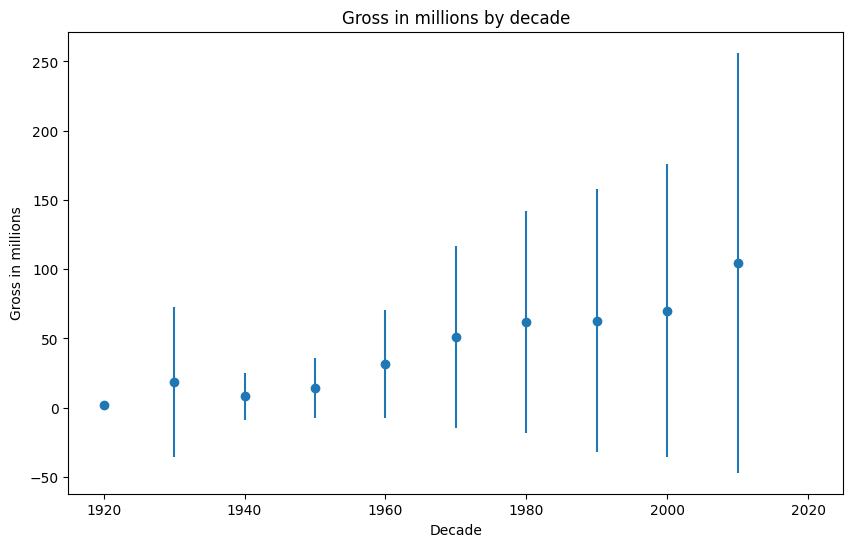

In [309]:
# Se grafica la media y std de cada decada
plt.figure(figsize=(10, 6))
plt.errorbar(g_p_d.index, g_p_d['mean'], yerr=g_p_d['std'], fmt='o')
plt.title('Gross in millions by decade')
plt.xlabel('Decade')
plt.ylabel('Gross in millions')
plt.show()

Se confirma que la desviación estándar de la columna 'gross_in_millions', en la mayoría de decadas, es mucho mas baja al agrupar por dicha variable, por lo que se procede a imputar los valores nulos con la media de la decada correspondiente.

Además, ya que para la decada de 2020 no se tiene información, se procede a imputar basandose en los valores de la decada de 2010, ya que se evidencia cómo esta variable tiene una tendencia, a pesar de un poco osculatoria, creciente.

In [310]:
# Se imputan los valores nulos con la media de la decada correspondiente
df_preprocess['gross_in_millions'] = df_preprocess['gross_in_millions'].fillna(df_preprocess['year'].apply(lambda x: g_p_d.loc[(x//10)*10]['mean']))

# Se imputan los valores nulos de la decada de 2020 con la media de la decada de 2010
df_preprocess['gross_in_millions'] = df_preprocess['gross_in_millions'].fillna(df_preprocess['year'].apply(lambda x: g_p_d.loc[2010]['mean']))

# Se verifica que no hayan valores nulos en la columna 'gross_in_millions'
df_preprocess['gross_in_millions'].isnull().sum()


0

Ya que se imputarón los datos en todos los valores nulos de la columna 'gross_in_millions' y se procede a verificar que las imputaciones se realizaron correctamente.

In [311]:
## Se verifica si el valor de una pelicula (Soorarai Pottru), cuyo valor se conocía era nulo, se imputó correctamente

validation_row = df_preprocess[df_preprocess['name'].str.contains('Soorarai Pottru')]
decade = 2010

# Se halla la media de la decada
mean = g_p_d.loc[decade]['mean']

# Se verifica si el valor imputado es igual a la media de la decada
validation_row['gross_in_millions'].values[0] == mean

True

A continuación se realiza la **imputación de los valores nulos de la columna 'metascore'**. Se procede a analizar los estadísticos de la columna 'metascore' para determinar la mejor forma de imputar los valores nulos.

In [312]:
# Se hallan los estadísiticos de la variable
df_preprocess['metascore'].describe()

count    841.000000
mean      78.158145
std       12.289270
min       28.000000
25%       71.000000
50%       79.000000
75%       87.000000
max      100.000000
Name: metascore, dtype: float64

Notemos que la varianza no es tan alta como para no imputar por la media, por ende, se procede a realizar la imputación.

In [313]:
# Realizar la imputacion
df_preprocess['metascore'] = df_preprocess['metascore'].fillna(df_preprocess['metascore'].mean())

Finalmente se verifica la cantidad de nulos en el dataframe, luego de haber realizado todas las imputaciones.

In [314]:
assert df_preprocess.isnull().sum().sum() == 0

## Análisis Exploratorio de Datos (EDA)

Para el análisis exploratorio de datos se utilizará la base antes de la imputación de los datos nulos con el objetivo de obtener una mirada más cercana de la base de datos original.

Primero, observaremos las dimensiones del dataset

In [315]:
df_eda.shape

(1000, 29)

Podemos observar que el dataset consta de 1000 registros y 29 columnas. Ahora observaremos los nombres de las columnas y su tipo de datos.

In [316]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               1000 non-null   object 
 1   year               1000 non-null   int64  
 2   runtime            1000 non-null   int64  
 3   rating             1000 non-null   float64
 4   metascore          841 non-null    float64
 5   timeline           1000 non-null   object 
 6   votes              1000 non-null   int64  
 7   gross_in_millions  829 non-null    float64
 8   genre_Drama        1000 non-null   int64  
 9   genre_Crime        1000 non-null   int64  
 10  genre_Action       1000 non-null   int64  
 11  genre_Adventure    1000 non-null   int64  
 12  genre_Biography    1000 non-null   int64  
 13  genre_History      1000 non-null   int64  
 14  genre_Sci-Fi       1000 non-null   int64  
 15  genre_Romance      1000 non-null   int64  
 16  genre_Western      1000 non-nu

Como podemos observar, 21 de estas columnas pertenecen al preprocesamiento realizado anteriormente del género de las películas. Las otras 8 columnas constan del nombre de la película (name), año en que salió (year), duración (runtime), puntuación (rating), metascore en IMDB (metascore), descripción corta (timeline), número de votos en IMDB (votes) y dinero recaudado en taquilla (gross_in_millions).

Vamos a ver las estadísticas descriptivas de las columnas numéricas de interés

In [317]:
# Seleccionamos las columnas numéricas de interés
columnas_especificas = ['year', 'runtime', 'rating', 'metascore', 'votes', 'gross_in_millions']
df_eda[columnas_especificas].describe()

year      runtime       rating   metascore         votes  \
count  1000.000000  1000.000000  1000.000000  841.000000  1.000000e+03   
mean   1991.238000   123.017000     7.954000   78.158145  2.790882e+05   
std      23.403014    28.212598     0.276008   12.289270  3.343180e+05   
min    1920.000000    45.000000     7.600000   28.000000  2.511600e+04   
25%    1976.000000   103.000000     7.700000   71.000000  5.577425e+04   
50%    1999.000000   119.000000     7.900000   79.000000  1.415310e+05   
75%    2010.000000   137.000000     8.100000   87.000000  3.809945e+05   
max    2021.000000   321.000000     9.300000  100.000000  2.394059e+06   

       gross_in_millions  
count         829.000000  
mean           68.153329  
std           109.950105  
min             0.000000  
25%             3.200000  
50%            23.090000  
75%            83.010000  
max           936.660000

Ahora, vamos a visualizar los datos. Primero, realizaremos histogramas para observar la distribución de los datos de las columnas numéricas

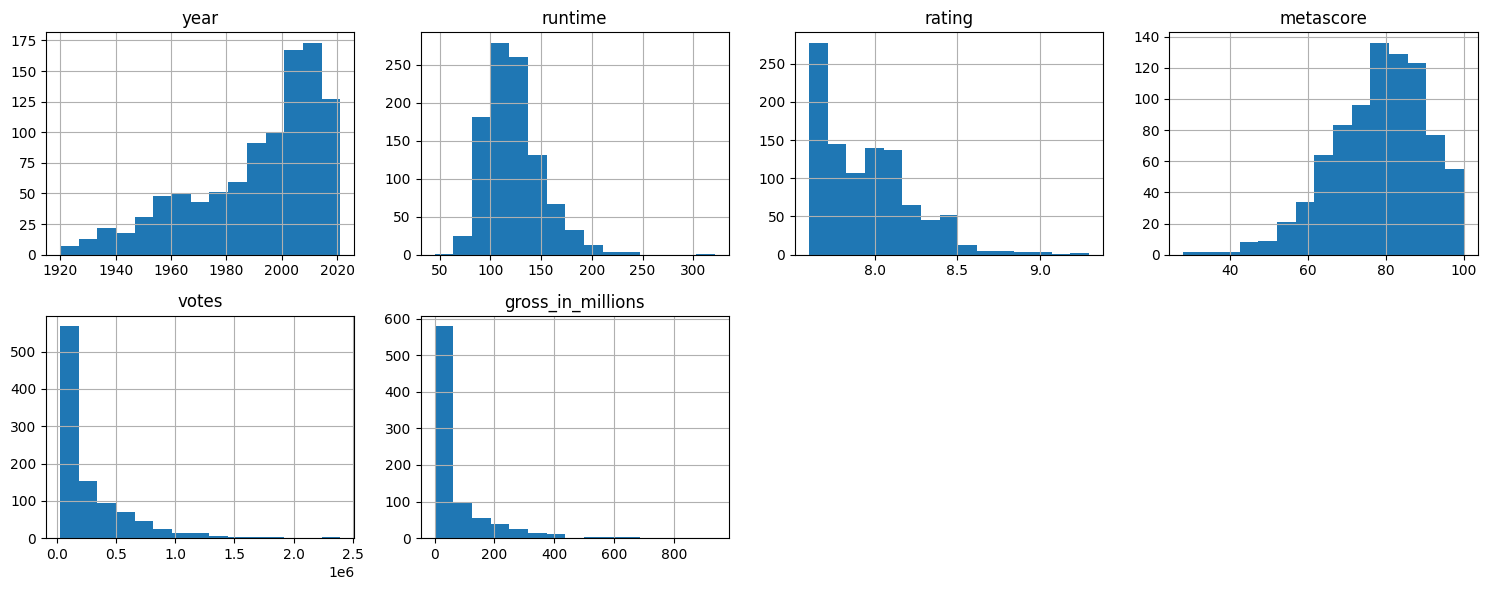

In [318]:
df_eda[columnas_especificas].hist(bins=15, figsize=(15, 6), layout=(2, 4))
plt.tight_layout()
plt.show()

Ahora, realizamos una matriz de correlación, utilizando la correlación de Pearson (dada por defecto)

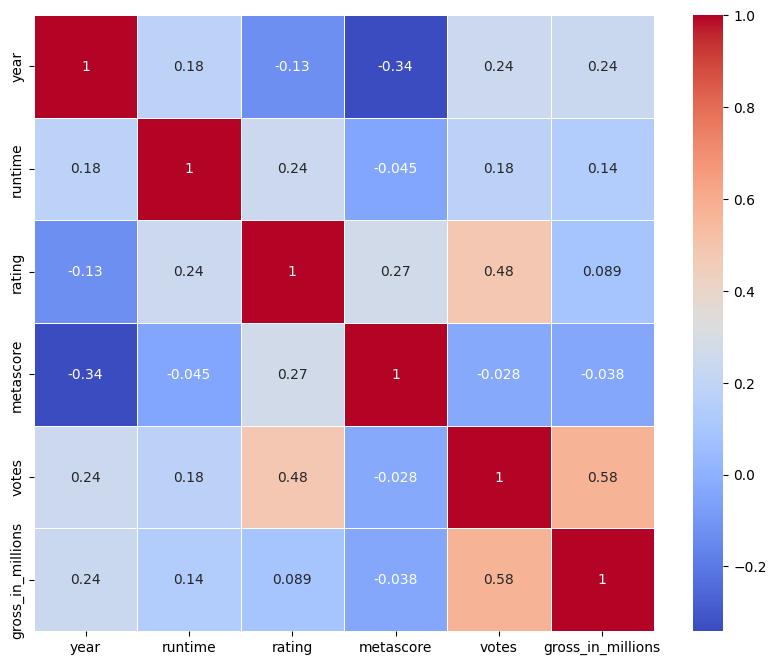

In [319]:
corr_matrix = df_eda[columnas_especificas].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

Realizaremos una matriz de dispersión para ver cómo se relacionan los datos

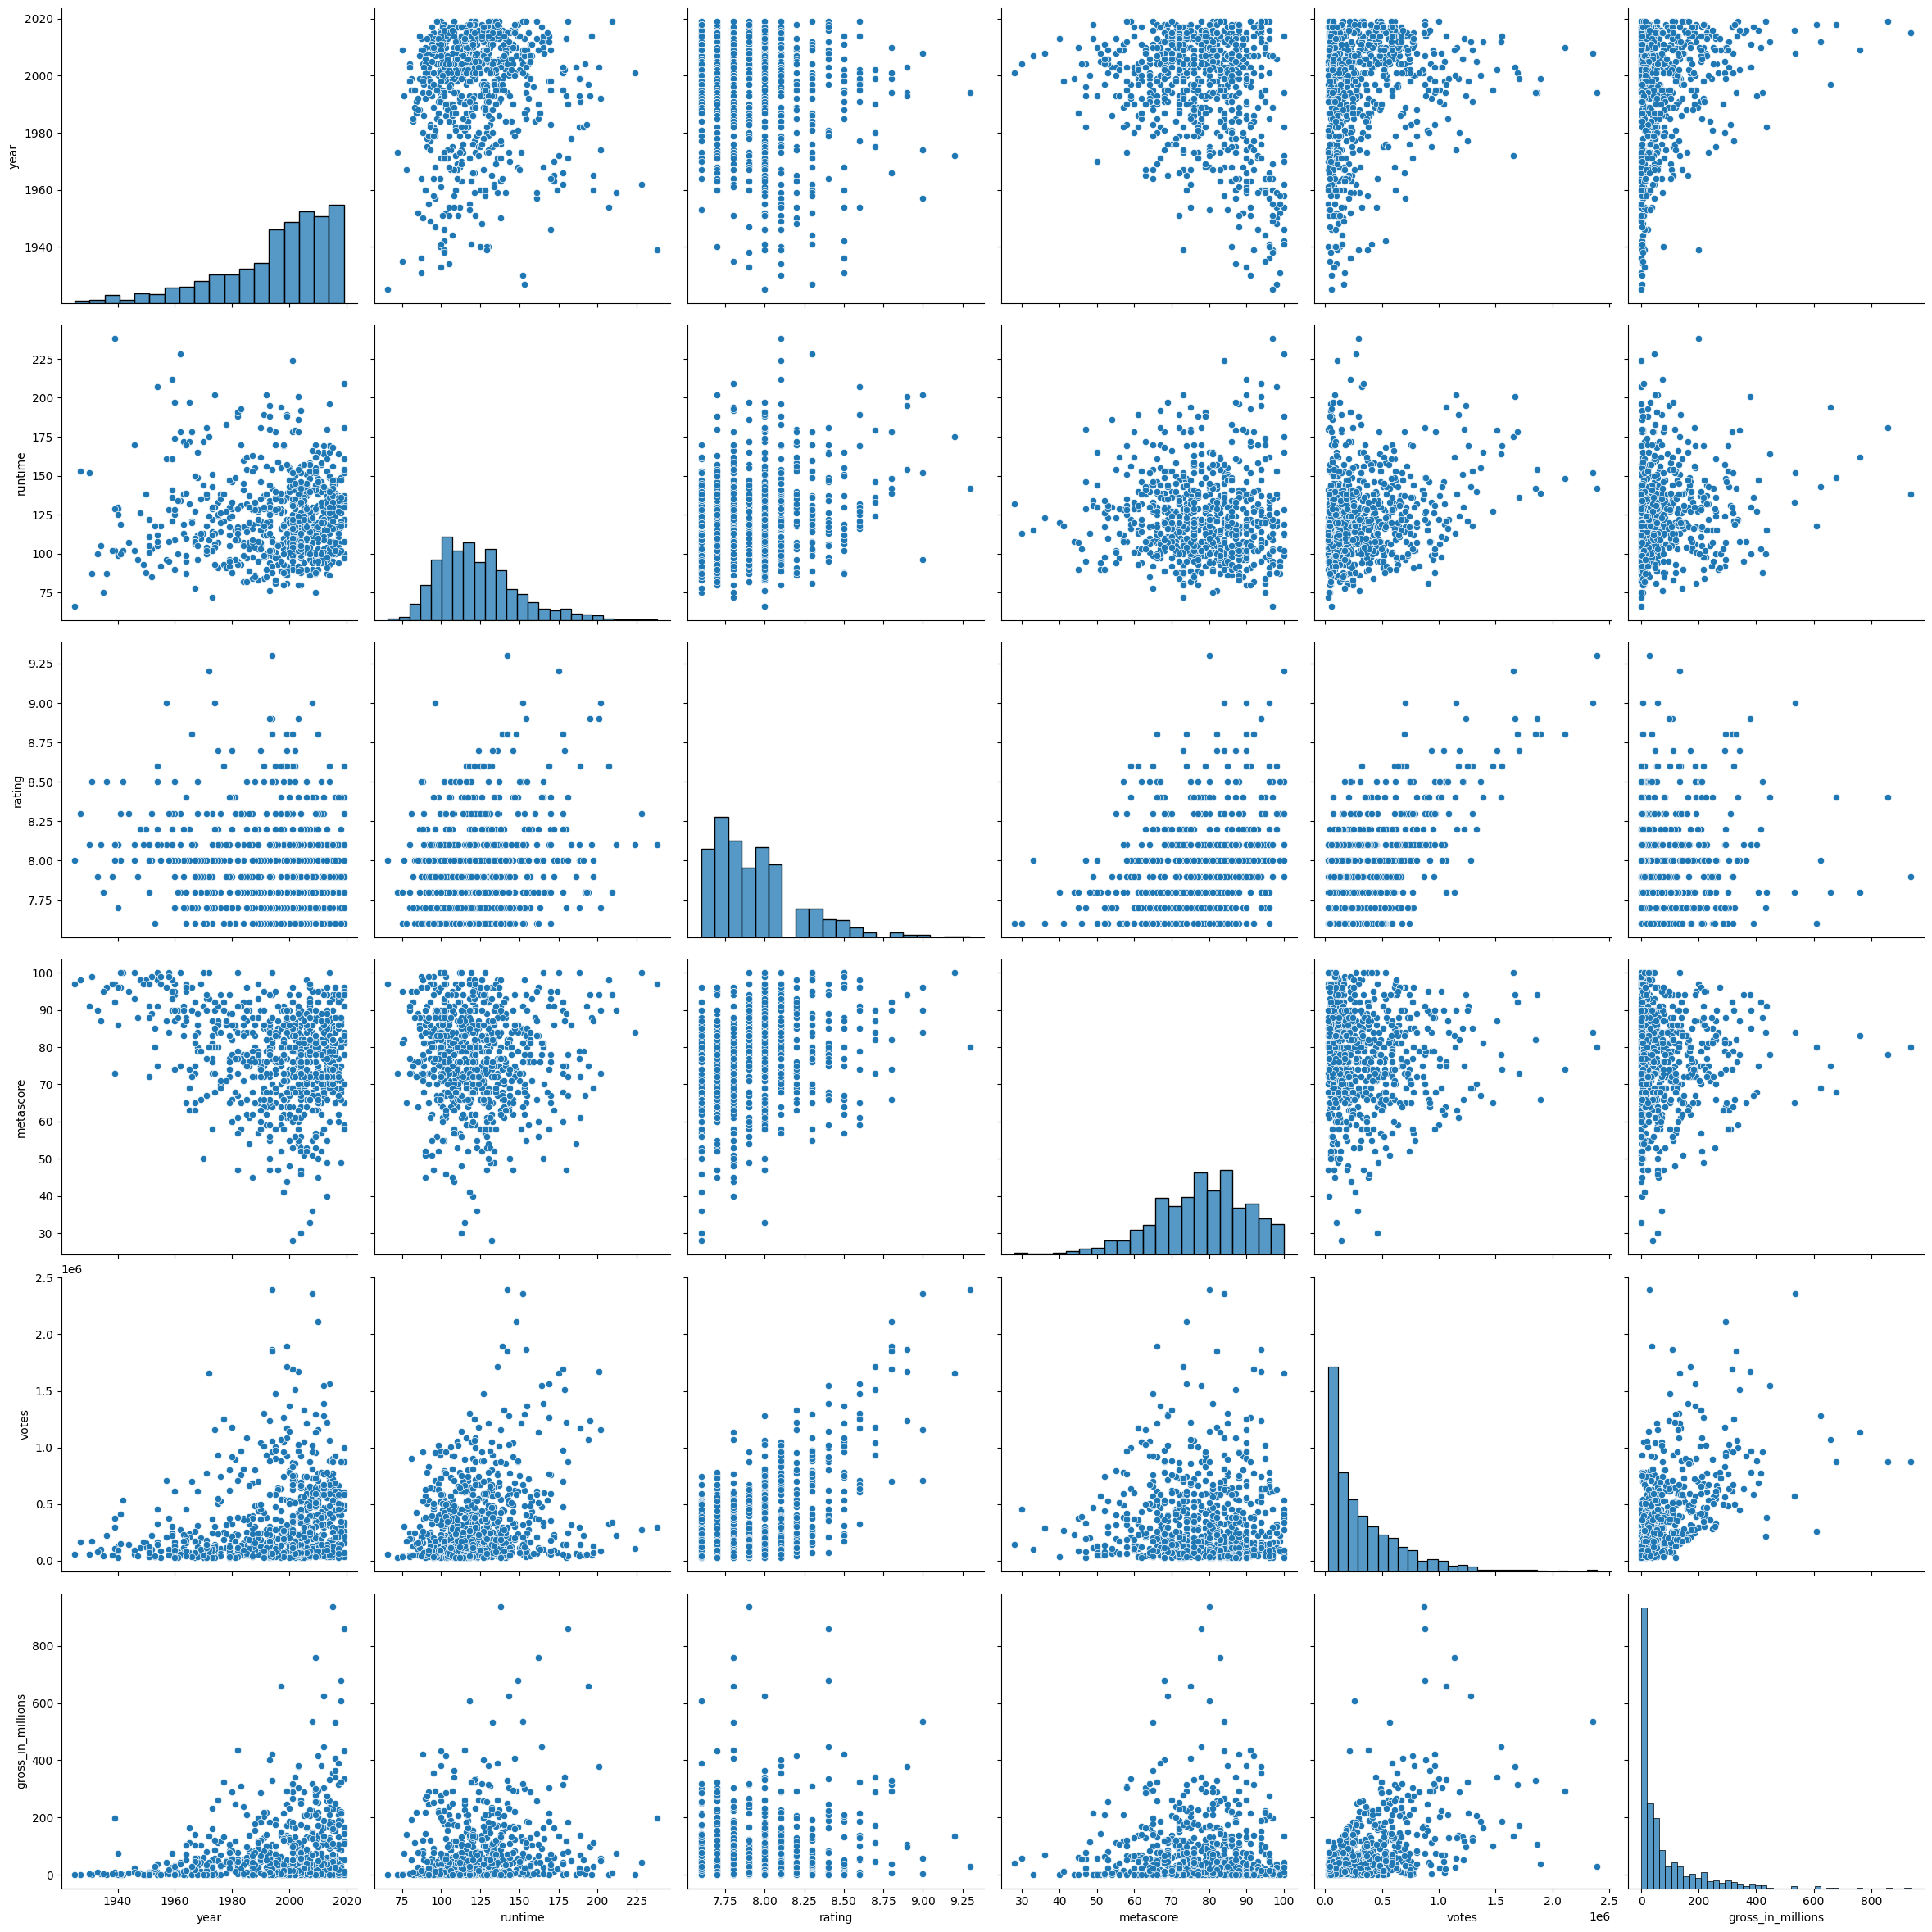

In [320]:
sns.pairplot(df_eda.dropna(),
            height=4,
            vars=columnas_especificas,
            kind='scatter')
plt.show()

Adicionalmente, realizaremos un análisis de los géneros

<ipython-input-321-1e89ca0095b5>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




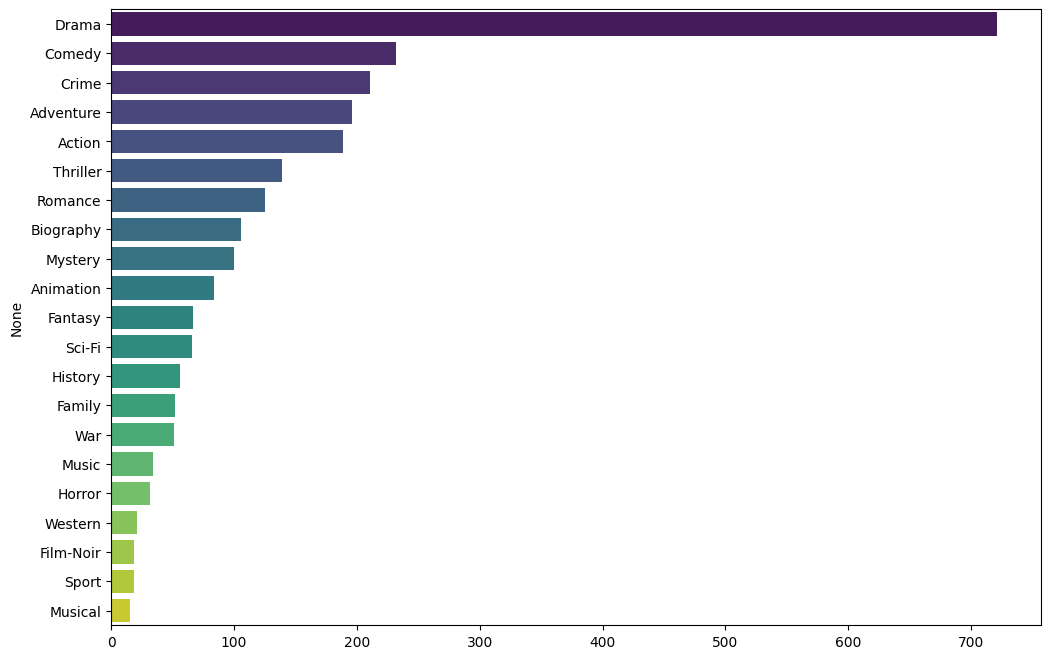

In [321]:
# Conteo de número de películas por género

genre_counts = df['genre'].str.get_dummies(sep=', ').sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.show()

<ipython-input-322-d6d394b1d7fc>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-322-d6d394b1d7fc>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




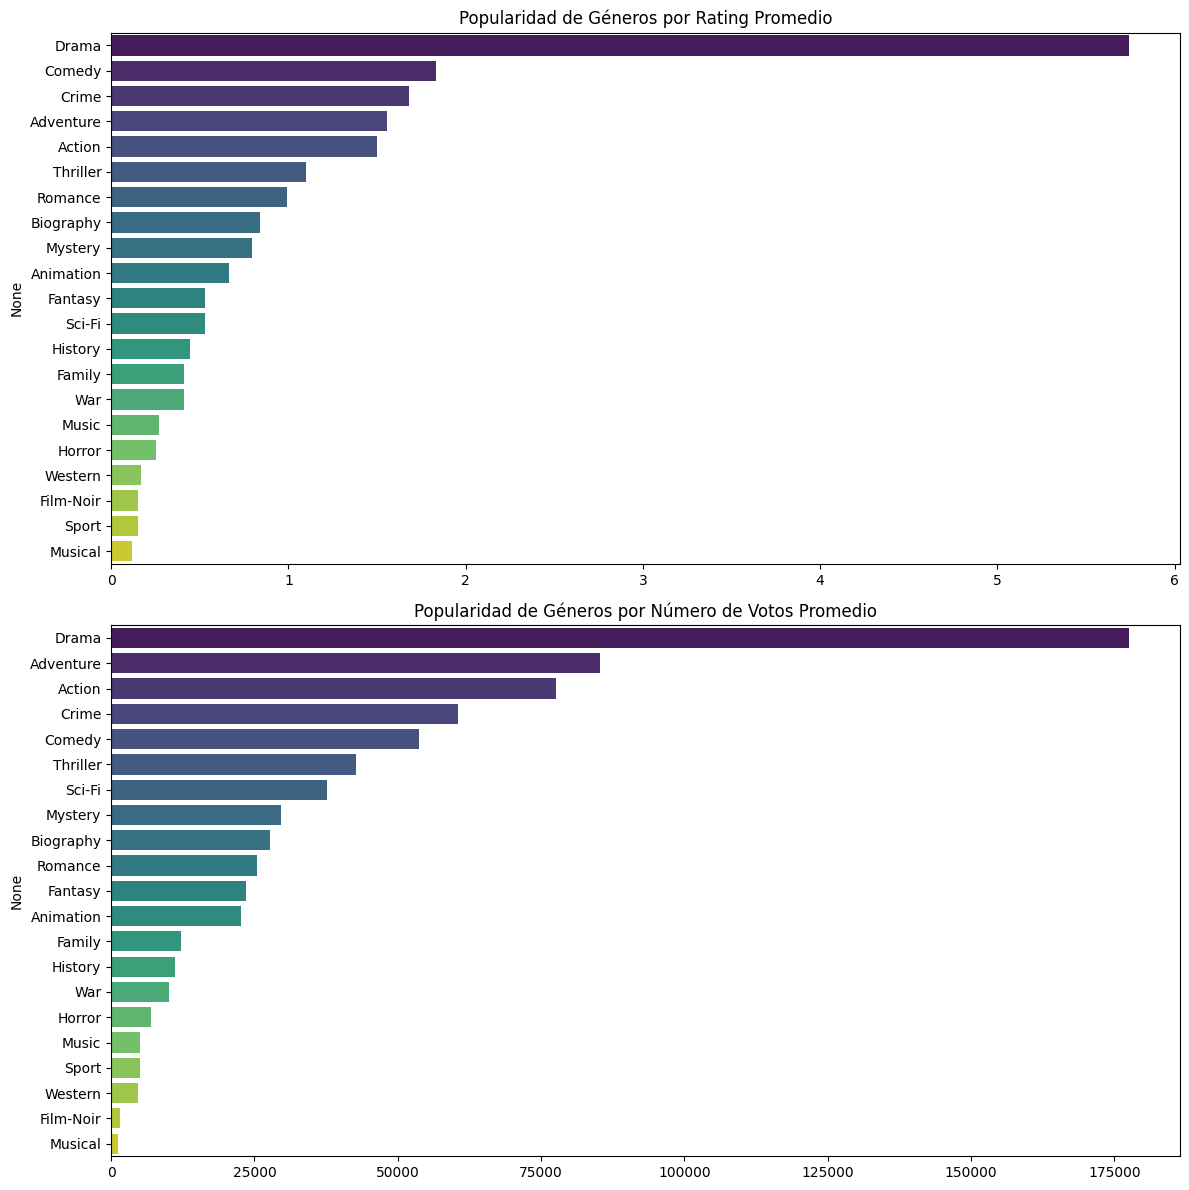

In [322]:
# Análisis de popularidad de géneros

genre_rating = df['genre'].str.get_dummies(sep=', ').mul(df_preprocess['rating'], axis=0).mean().sort_values(ascending=False)
genre_votes = df['genre'].str.get_dummies(sep=', ').mul(df_preprocess['votes'], axis=0).mean().sort_values(ascending=False)

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

sns.barplot(x=genre_rating.values, y=genre_rating.index, palette='viridis', ax=axes[0])
axes[0].set_title('Popularidad de Géneros por Rating Promedio')

sns.barplot(x=genre_votes.values, y=genre_votes.index, palette='viridis', ax=axes[1])
axes[1].set_title('Popularidad de Géneros por Número de Votos Promedio')

plt.tight_layout()
plt.show()

Ahora, para tener una idea más clara de las variables que mejor describen el dataset, vamos a realizar un análisis de componentes principales

In [323]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalizamos las variables numéricas
features = ['rating', 'runtime', 'votes', 'gross_in_millions', 'metascore']

#features = ['year', 'runtime', 'rating', 'metascore', 'votes', 'gross_in_millions']
x = df_preprocess[features].values
x = StandardScaler().fit_transform(x)

# Aplicamos el análisis de componentes principales
pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)

# Creamos un dataframe con los componentes principales
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

# Obtenemos las cargas de los componentes principales
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Creamos un dataframe para visualizar las cargas
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=features)

loadings_df


PC1       PC2       PC3
rating             0.681702 -0.517556  0.103077
runtime            0.460936  0.011593  0.828619
votes              0.872264  0.143501 -0.228296
gross_in_millions  0.677265  0.451482 -0.333678
metascore          0.099763 -0.836671 -0.271495

Según el análisis de componentes principales, para el componente 1 tienen mayor carga las variables de votes y gross_in_millions; para el componente 2, tiene mayor carga la variable metascore y rating; y para el componente 3, tiene mayor carga la variable runtime.

A partir de esto, y teniendo en cuenta la correlación de las variables, las 3 variables a escoger que describen la base de datos son **rating**, **votes** y **gross_in_millions**.

Podemos observar a continuación la distribución de las variables de manera tridimensional

In [324]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter_3d(df_preprocess, x="votes", y="rating", z="gross_in_millions")
fig.show()

## Elección del número óptimo de clústeres k

Primero, vamos a mezclar los registros de forma aleatoria

In [325]:
np.random.seed(0)
df_preprocess = df_preprocess.sample(frac=1).reset_index(drop=True)

Seleccionamos las tres variables más relevantes elegidas previamente

In [326]:
# Variables más relevantes
columns = ['rating', 'votes', 'gross_in_millions']
df_relevantes = df_preprocess[columns]

Normalizamos las variables numéricas

In [327]:
# Normalizamos las variables
scaler = StandardScaler()
df_norm = scaler.fit_transform(df_relevantes)

Determinar el número óptimo de clústeres utilizando
* Curva de codo
* Método del estadístico de gap
* Análisis de la silueta.

### Curva de codo
Para tener un indicio del número óptimo de clústeres, primero se utilizará el método de la curva de codo, el cual consiste en graficar la inercia (suma de las distancias cuadradas dentro de los clústeres) en función del número de clústeres k.

Se observa cómo la inercia disminuye a medida que se incrementa k. El punto donde la tasa de disminución de la inercia se vuelve menos pronunciada, formando un ángulo parecido a un codo, indica el número óptimo de clústeres.

In [328]:
def elbow_curve(data, maxClusters = 15):
    maxClusters = range(1, maxClusters + 1)
    inertias = []

    for k in maxClusters:
        kmeanModel = KMeans(n_clusters=k, n_init=10)
        kmeanModel.fit(data)
        inertias.append(kmeanModel.inertia_)

    plt.figure(figsize=(10, 8))
    plt.plot(maxClusters, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

    # Calcula las diferencias finitas
    first_derivative = np.diff(inertias)
    second_derivative = np.diff(first_derivative)

    # Imprime los valores de las segundas derivadas
    print("Segundas derivadas: ", second_derivative)

    # Encuentra el punto donde la segunda derivada cambia de signo
    inflection_points = np.where(np.diff(np.sign(second_derivative)))[0]

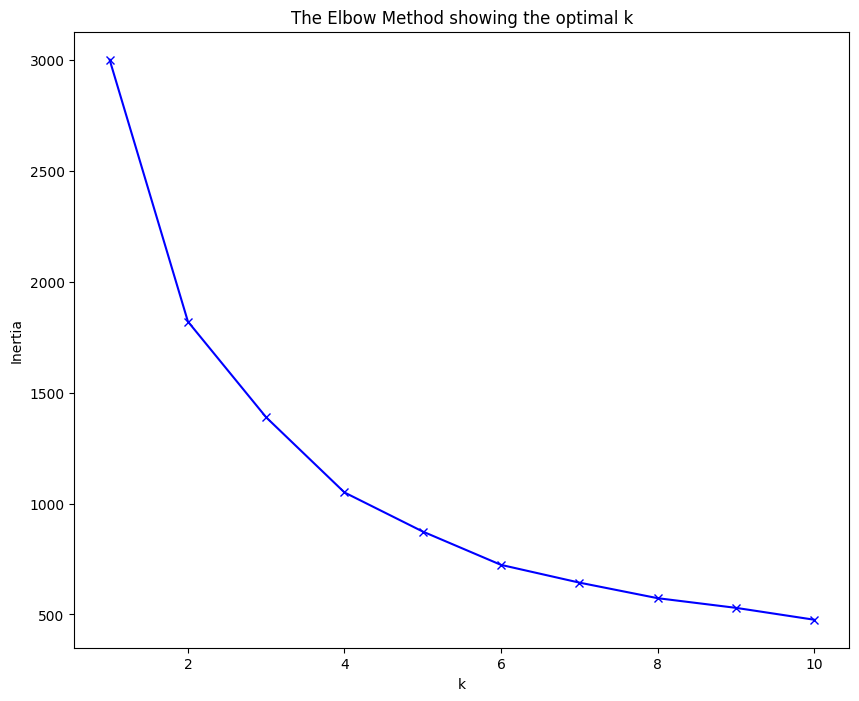

Segundas derivadas:  [748.15921577  93.30734256 162.26228024  25.93623101  70.35947772
   9.7000164   26.6487529  -10.00994353]


In [329]:
elbow_curve(df_norm, maxClusters = 10)

La gráfica del método del codo muestra una disminución significativa en la inercia hasta \( k = 2 \) y luego hasta \( k = 4 \), donde la curva empieza a aplanarse. Este punto indica una reducción notable de mejoras al agregar más clusters.

Adicionalmente, al observar las segundas derivadas, se puede observar que, aunque no cambian de signo, \( k = 2 \) y  \( k = 4 \) podrían tomarse como puntos de inflexión dada su variación con el k anterior y el siguiente.

Por lo tanto, se continuará con la evaluación del número óptimo de clústeres con los otros métodos.

### Estadístico de GAP
A continuación se define la función que calcula el estadístico de GAP, el cual consisteen comparar la variación del agrupamiento dentro de los datos observados con la variación esperada bajo un modelo nulo, es decir, datos distribuidos aleatoriamente. El número óptimo de clústeres es aquel k que maximiza el valor del estadístico de GAP


In [330]:
def optimalK(data, nrefs=3, maxClusters=15):
    # Inicializa un arreglo para almacenar las estadísticas de gap
    gaps = np.zeros((len(range(1, maxClusters+1)),))
    # Crea un DataFrame para almacenar los resultados de gap
    resultsdf = pd.DataFrame({'clusterCount': [], 'gap': []})

    # Itera sobre el rango de número de clusters (k)
    for gap_index, k in enumerate(range(1, maxClusters+1)):
        # Inicializa un arreglo para las dispersiones de referencia
        refDisps = np.zeros(nrefs)

        # Genera dispersiones de referencia aleatorias
        for i in range(nrefs):
            np.random.seed(0)
            randomReference = np.random.random_sample(size=data.shape)
            km = KMeans(n_clusters=k, n_init=10)
            km.fit(randomReference)
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Calcula la dispersión del conjunto de datos original
        km = KMeans(n_clusters=k, n_init=10)
        km.fit(data)
        origDisp = km.inertia_

        # Calcula la estadística de gap
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        gaps[gap_index] = gap
        # Agrega el resultado al DataFrame de resultados
        resultsdf = pd.concat([resultsdf, pd.DataFrame({'clusterCount': [k], 'gap': [gap]})], ignore_index=True)

    # Determina el número óptimo de clusters basado en la estadística de gap
    for i in range(0, len(gaps)-1):
        if gaps[i+1] <= gaps[i]:
            optimal_clusters = i+1
            break
    else:
        optimal_clusters = len(gaps)

    # Mostrar la cantidad óptima de clusters
    print('La cantidad óptima de clusters es:', optimal_clusters)

    # Mostrar el gráfico de la estadística de gap versus K
    plt.figure(figsize=(16, 8))
    plt.plot(resultsdf['clusterCount'], resultsdf['gap'], linestyle='--', marker='o', color='b')
    plt.xlabel('K')
    plt.ylabel('Gap Statistic')
    plt.title('Gap Statistic vs. K')
    plt.show()

    return (optimal_clusters, resultsdf)


La cantidad óptima de clusters es: 4


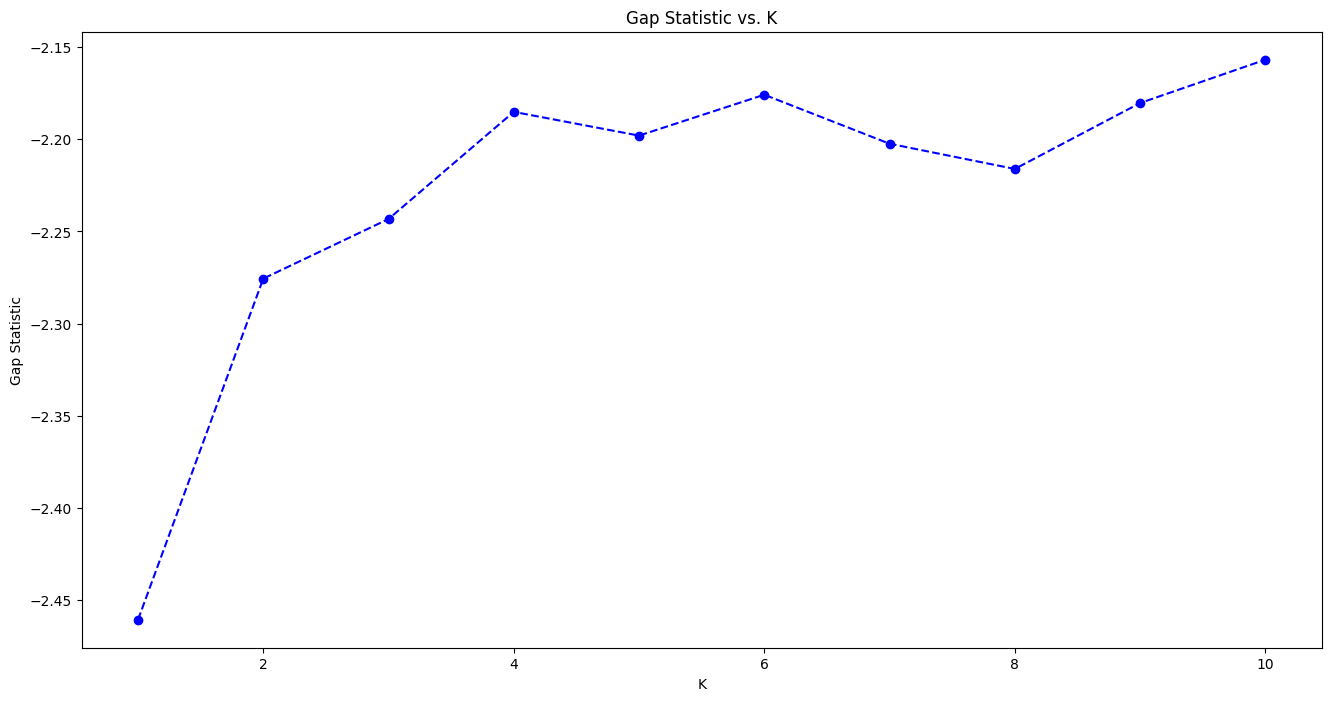

In [331]:
n_clusters, gapdf = optimalK(df_norm, nrefs=5, maxClusters=10)


Se puede ver que hasta k = 5 el valor del estadístico de gap iba creciendo de forma constante pero, cae respecto a su valor en k = 4.

Se selecciona cuatro como la cantidad óptima de clusters, que no difiere mucho del resultado obtenido por el metodo del codo.

### Análisis de la silueta

Finalmente, se realiza el análisis de la silueta para corroborar el número óptimo de clusters, el cual consiste en calcular la cohesión y separación de los puntos dentro de cada cluster. La puntuación de la silueta mide qué tan similar es un punto a su propio cluster en comparación con otros clusters, proporcionando un valor entre -1 y 1. El valor de k que maximiza el promedio de la puntuación de la silueta es considerado el número óptimo de clusters.

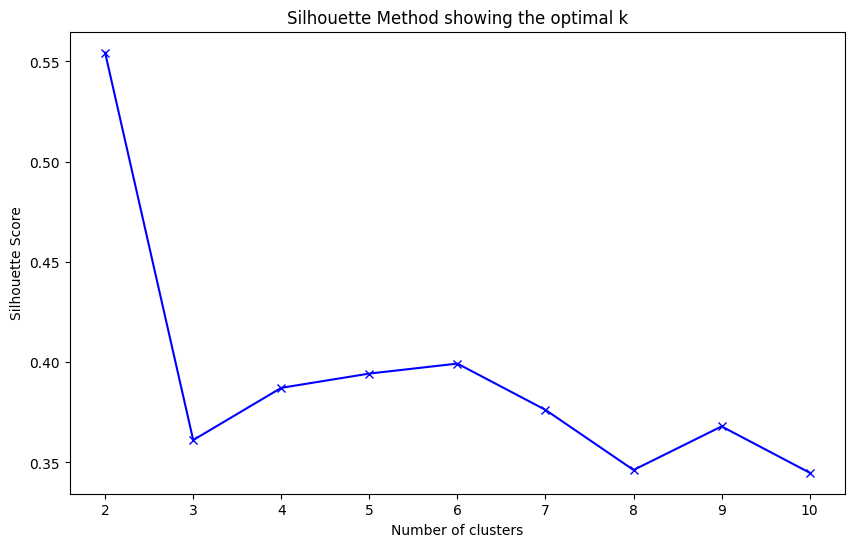

In [332]:
def silhouette_method(data, max_clusters=10):
    # Inicializa una lista para almacenar los puntajes promedio de la silueta
    silhouette_avgs = []

    # Itera sobre el rango de posibles números de clusters (k) desde 2 hasta max_clusters
    for k in range(2, max_clusters+1):
        # Aplica el algoritmo K-means al conjunto de datos con k clusters
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(data)

        # Obtiene las etiquetas de los clusters asignados por K-means
        cluster_labels = kmeans.labels_

        # Calcula el puntaje promedio de la silueta para las etiquetas de los clusters
        silhouette_avg = silhouette_score(data, cluster_labels)

        # Almacena el puntaje promedio de la silueta en la lista
        silhouette_avgs.append(silhouette_avg)

    # Plotea el número de clusters en el eje x y los puntajes promedio de la silueta en el eje y
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters+1), silhouette_avgs, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method showing the optimal k')
    plt.show()

# Llama a la función silhouette_method con el conjunto de datos normalizado
silhouette_method(df_norm)



A continuación se mostrará el gráfico de la silueta, junto con la representación gráfica de los clusters en sus dimensiones principales, esto nos permitirá pasar del simple estadístico a una referencia visual de la calidad de los clusters.

For n_clusters = 2 The average silhouette_score is : 0.5543553472445648
Número de datos en cada clúster para n_clusters = 2: {0: 843, 1: 157}


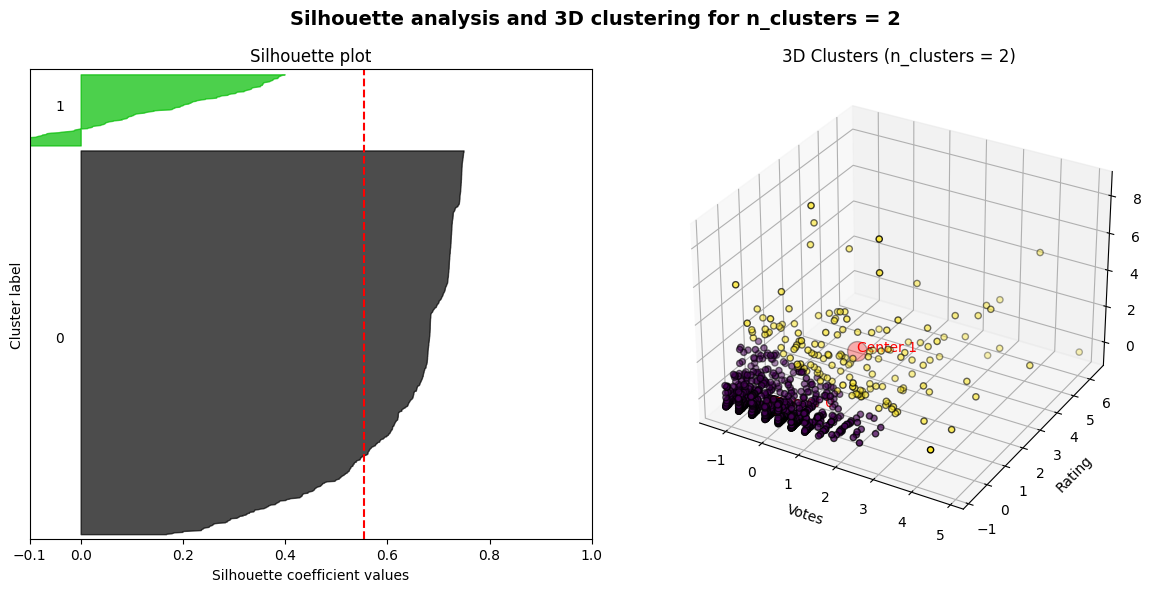

For n_clusters = 3 The average silhouette_score is : 0.3611776401804254
Número de datos en cada clúster para n_clusters = 3: {0: 498, 1: 124, 2: 378}


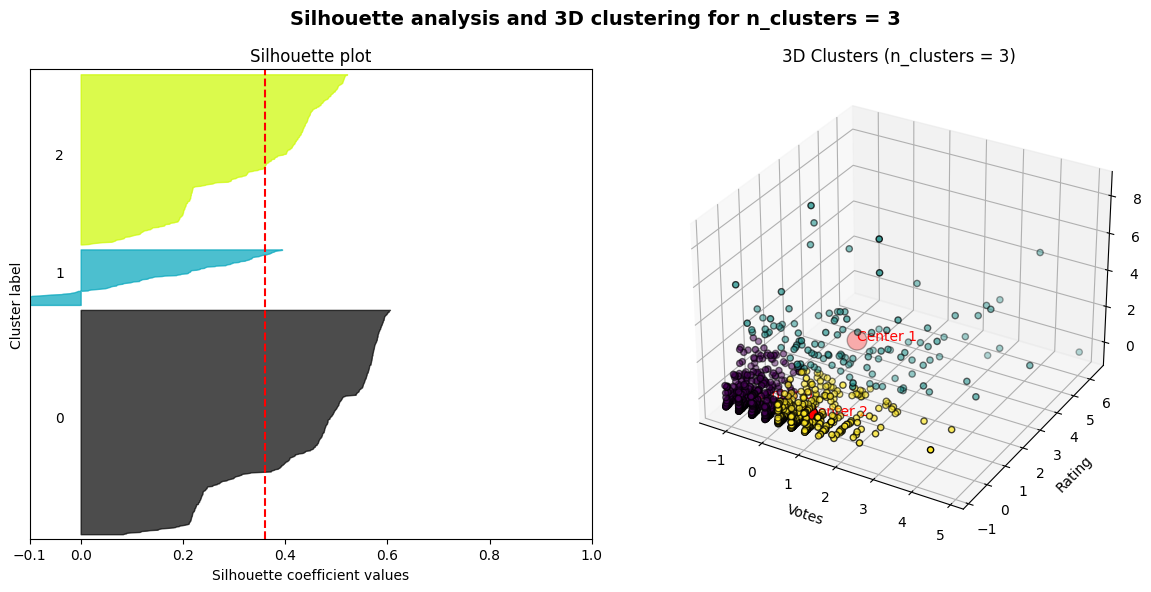

For n_clusters = 4 The average silhouette_score is : 0.38722388975197897
Número de datos en cada clúster para n_clusters = 4: {0: 469, 1: 362, 2: 65, 3: 104}


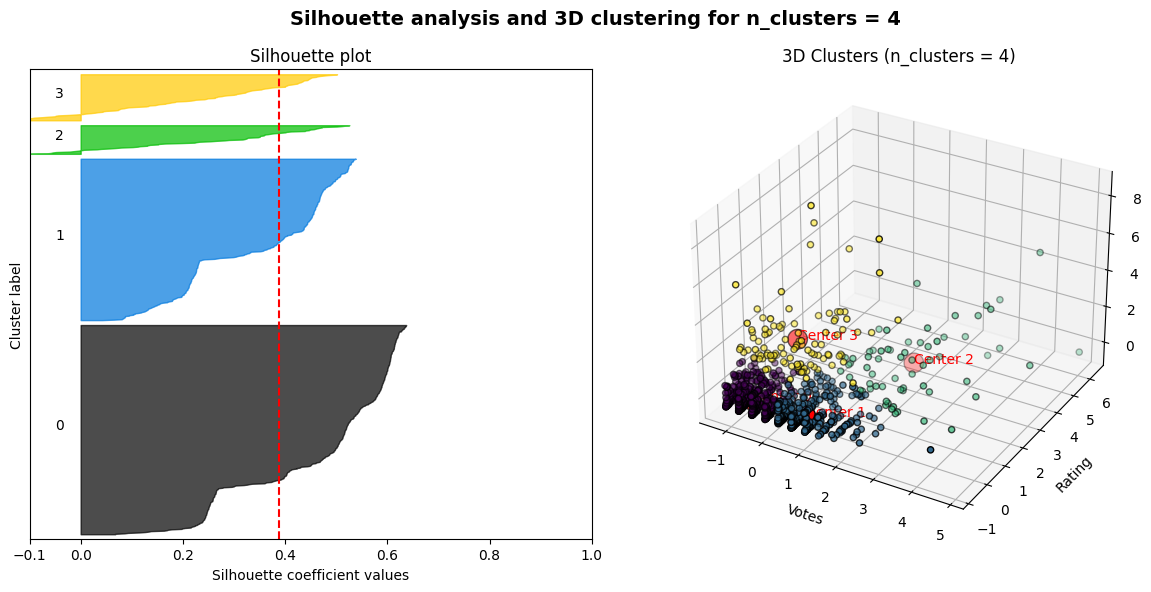

For n_clusters = 5 The average silhouette_score is : 0.39530415002376573
Número de datos en cada clúster para n_clusters = 5: {0: 449, 1: 121, 2: 21, 3: 61, 4: 348}


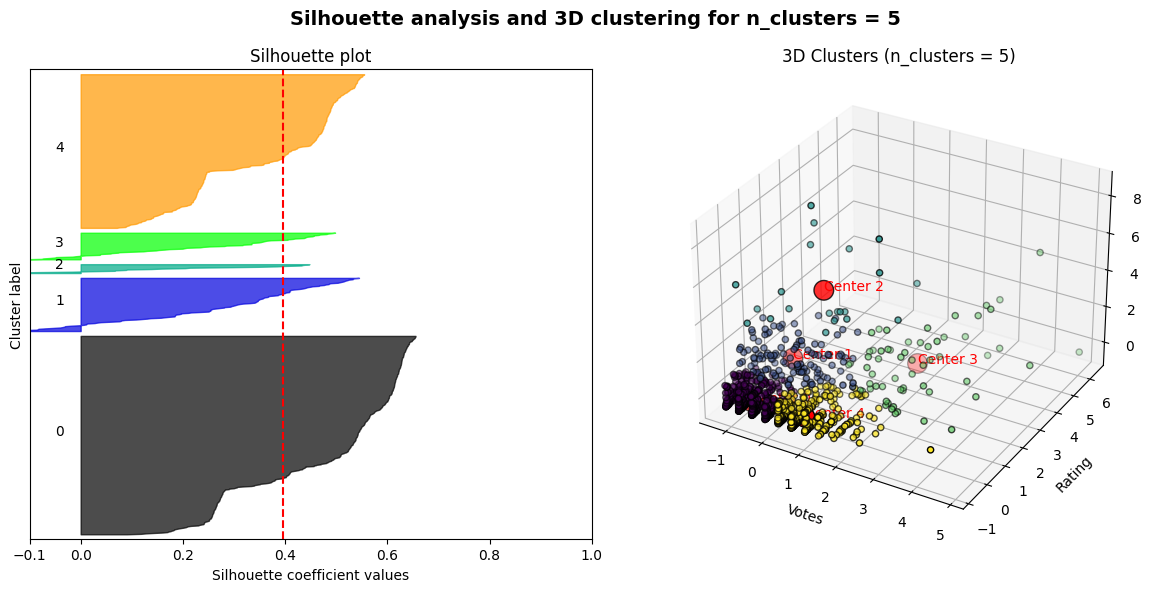

For n_clusters = 6 The average silhouette_score is : 0.4030842128223534
Número de datos en cada clúster para n_clusters = 6: {0: 318, 1: 459, 2: 84, 3: 8, 4: 98, 5: 33}


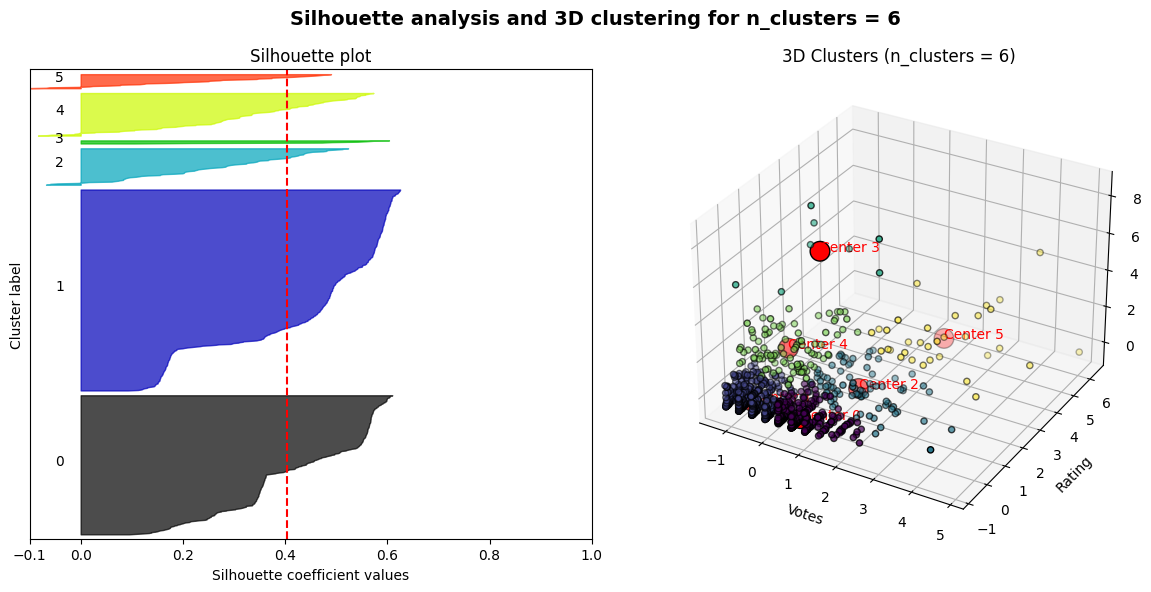

In [333]:
# Se definen las variables necesarias
range_n_clusters = [2, 3, 4, 5, 6]
X = df_norm

for n_clusters in range_n_clusters:
    fig = plt.figure(figsize=(12, 6))

    # Creamos un subplot con 1 fila y 2 columnas
    ax1 = fig.add_subplot(121)

    # El primer subplot es el gráfico de la silueta
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Inicializamos el clusterer con el valor de n_clusters y una semilla aleatoria de 10 para reproducibilidad
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init=10)
    cluster_labels = clusterer.fit_predict(X)

    # La puntuación de silueta da el valor promedio para todas las muestras
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Imprime el número de datos en cada clúster
    unique, counts = np.unique(cluster_labels, return_counts=True)
    print(f'Número de datos en cada clúster para n_clusters = {n_clusters}: {dict(zip(unique, counts))}')

    # Calculamos las puntuaciones de silueta para cada muestra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 para los 0 samples

    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Eliminamos etiquetas y ticks del eje y
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Gráfico 3D que muestra los clústeres formados
    ax2 = fig.add_subplot(122, projection='3d')
    scatter = ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=cluster_labels, cmap='viridis', edgecolor='k')
    ax2.set_title(f"3D Clusters (n_clusters = {n_clusters})")
    ax2.set_xlabel('Votes')
    ax2.set_ylabel('Rating')
    ax2.set_zlabel('Gross in Millions')

    # Dibujamos círculos blancos en los centros de los clústeres
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], centers[:, 2], marker='o', c='red', s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.text(c[0], c[1], c[2], f'Center {i}', color='red')

    plt.suptitle((f"Silhouette analysis and 3D clustering for n_clusters = {n_clusters}"),
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


Aunque para k=2 sea el valor más alto de la puntuación del método de la silueta, se puede observar que la distribución de los datos se concentra más en un clúster que en otro, por lo que no hay una buena distribución.

El siguiente valor más alto (para evitar un overfitting al elegir demasiados clústeres) es k=4, donde existe una buena distribución de los datos, y el valor de la puntuación del método de la silueta es más alto que en k=3.

Por lo tanto, dados los métodos de la curva de codo, el estadístico de GAP y el método de la silueta, el número de clústeres a elegir es k=4.

## Clustering K-Means

Realizamos la clusterización con K=4

In [334]:
# Creamos el modelo de clustering
kmeansClusters = KMeans(n_clusters=4).fit(df_norm)
df_preprocess['cluster'] = kmeansClusters.fit_predict(df_norm)

# Creamos una subgráfica en 3D para visualizar los clusters
fig = px.scatter_3d(df_preprocess, x="votes", y="rating", z="gross_in_millions", color="cluster")
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



## Agrupamiento Jerárquico Aglomerativo

El agrupamiento jerárquico es una técnica de clustering que organiza los datos en una estructura jerárquica de árboles, llamada dendrograma. En este caso, utilizaremos el método aglomerativo, empleando el enlace de Ward (para calcular la distancia entre clusters) y la métrica de distancia euclidiana.

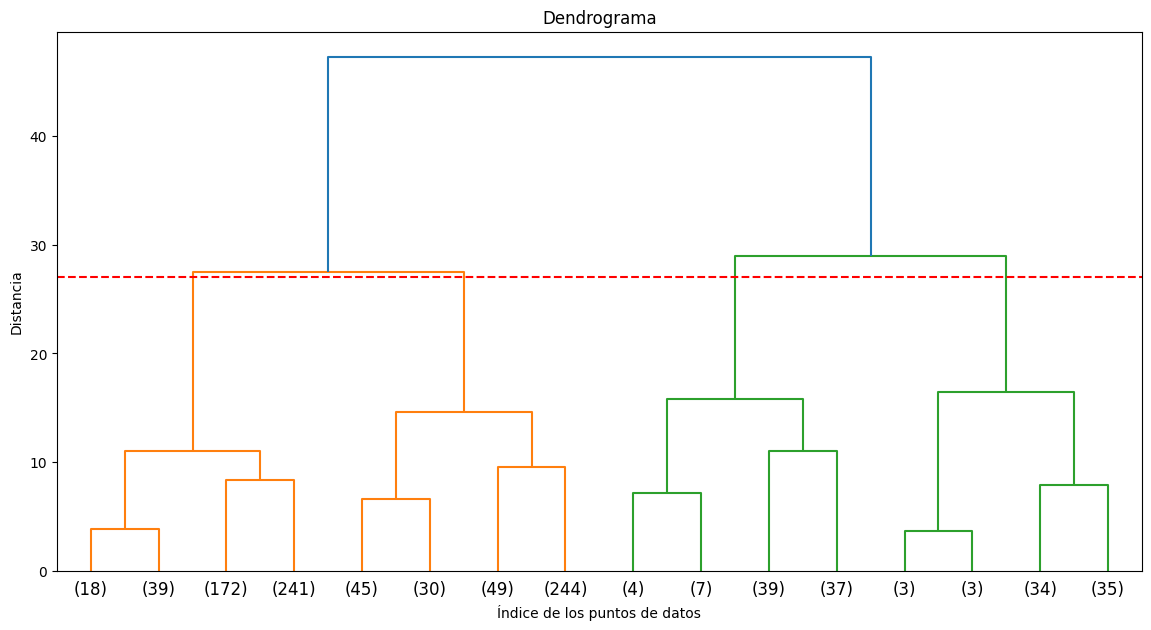

In [335]:
plt.figure(figsize=(14, 7))
dend = shc.dendrogram(shc.linkage(df_norm, method='ward'),truncate_mode='level',p=3)
plt.title("Dendrograma")
plt.xlabel('Índice de los puntos de datos')
plt.ylabel('Distancia')
plt.axhline(y=27, color='r', linestyle='--')  # Línea horizontal
plt.show()

En el dendrograma del clustering jerárquico aglomerativo, se observa una línea horizontal roja que corta el dendrograma a un nivel específico de distancia. Esta línea indica el punto de corte que define los clusters. Al cortar el dendrograma en este punto, se forman 4 clusters claramente separados. Este corte fue elegido porque a esta altura, las distancias entre los clusters fusionados son grandes, lo que sugiere que los clusters son bien definidos y distintos entre sí.

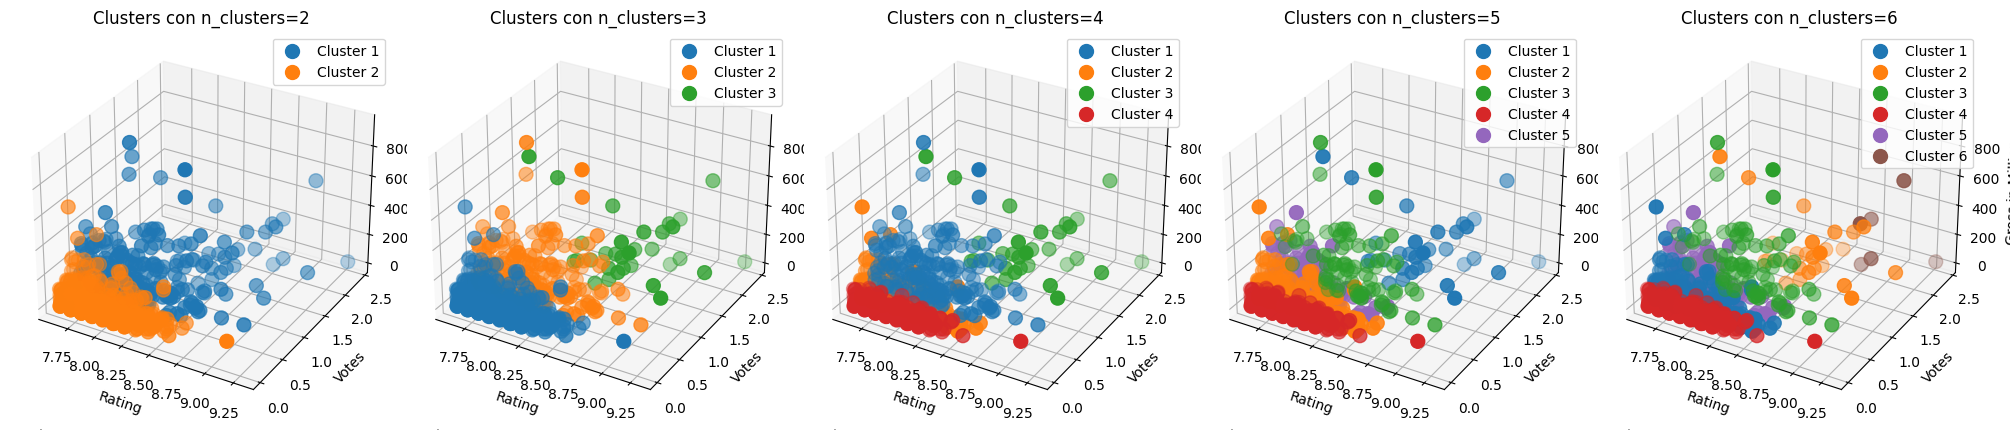

In [336]:
X = df_preprocess[columns]

# Rango de números de clusters
cluster_ranges = range(2, 7)  # Desde 2 hasta 6 clusters

# Crear el número adecuado de subgráficas
fig = plt.figure(figsize=(20, 5))

for i, n_clusters in enumerate(cluster_ranges):
    # Crear el modelo de clustering aglomerativo
    hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    y_hc = hc.fit_predict(X)

    # Crear una subgráfica en 3D
    ax = fig.add_subplot(1, len(cluster_ranges), i + 1, projection='3d')
    for cluster in range(n_clusters):
        ax.scatter(X.iloc[y_hc == cluster, 0], X.iloc[y_hc == cluster, 1], X.iloc[y_hc == cluster, 2], s=100, label=f'Cluster {cluster + 1}')
    ax.set_title(f'Clusters con n_clusters={n_clusters}')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Votes')
    ax.set_zlabel('Gross in Millions')
    ax.legend()

plt.tight_layout()
plt.show()

En los gráficos, los 4 clusters evidencian ser la mejor elección porque balancean la dispersión de los datos y la diferenciación entre grupos. En el gráfico con 4 clusters, los grupos están bien definidos y no hay un exceso de solapamiento como se observa en los gráficos con 5 y 6 clusters. Además, se evita la simplificación excesiva que se presenta en el gráfico con 2 clusters, donde los grupos no capturan toda la variabilidad de los datos.

In [337]:
# Número de clusters
n_clusters = 4

# Creamos el modelo de clustering aglomerativo
hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
df_preprocess['cluster_Aglomerativo'] = hc.fit_predict(X)

# Creamos una subgráfica en 3D para visualizar los clusters
fig = px.scatter_3d(df_preprocess, x="votes", y="rating", z="gross_in_millions", color="cluster_Aglomerativo")
fig.show()

Finalmente, como valor agregado, comparamos ambos métodos, realizando un conteo por clase

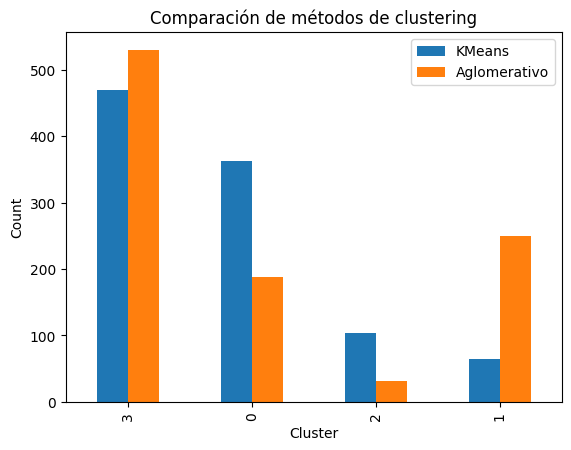

In [338]:
# Graficamos la comparación
kmean = pd.Series(kmeansClusters.labels_, name="kmeans").value_counts()
aglomerativo = pd.Series(hc.labels_, name="aglomerativo").value_counts()

comp_metodos = pd.merge(kmean, aglomerativo, left_index=True, right_index=True)

comp_metodos.plot.bar()
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Comparación de métodos de clustering')
plt.legend(['KMeans', 'Aglomerativo'])

plt.show()

Para la caracterización de los datos por cluster, utilización del modelo y análisis de tendencias se utilizará el **Clustering KMeans**

In [339]:
# Conservamos una única columna de clúster, en este caso, la del clustering KMeans, eliminando la del clustering jerárquico
df_preprocess = df_preprocess.drop(columns=['cluster_Aglomerativo'])

## Características representativas por cluster

Vamos a graficar la media de cada variable por cluster

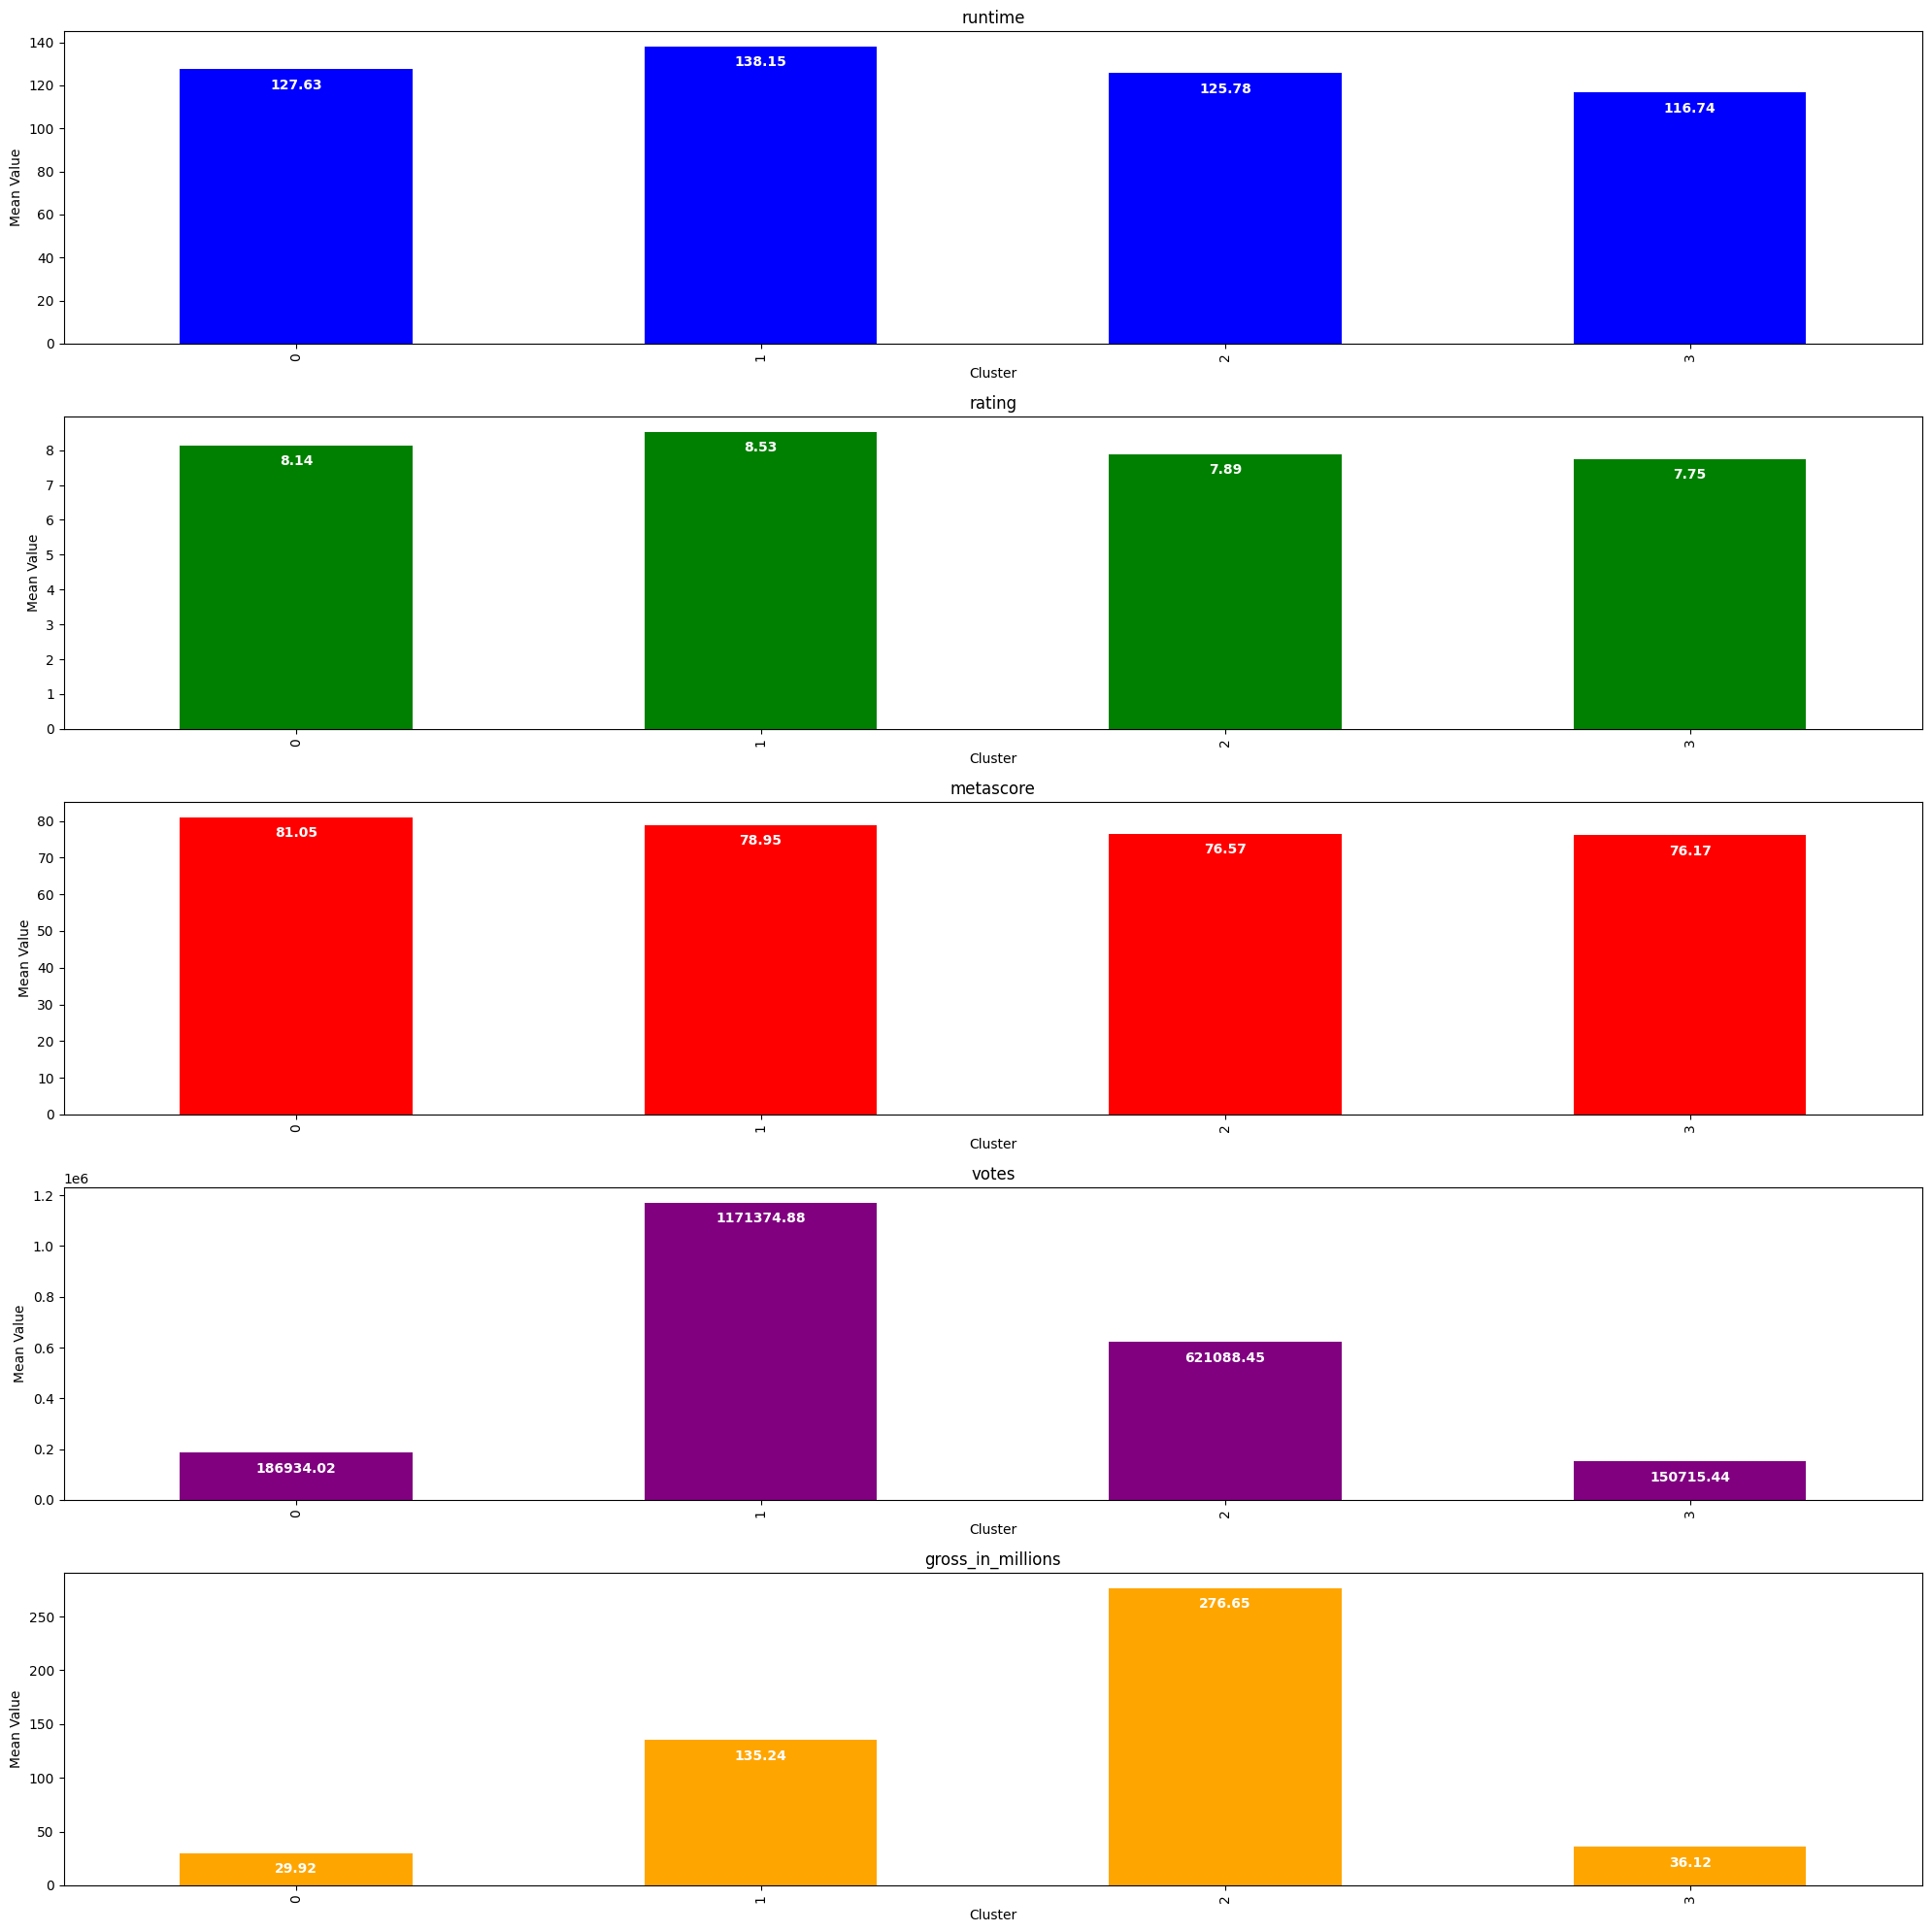

In [340]:
# Calculamos el promedio por cluster
mean_values = df_preprocess[['runtime', 'rating', 'metascore', 'votes', 'gross_in_millions', 'cluster']].groupby("cluster").mean()

# Creamos subplots de barras para cada columna
fig, axes = plt.subplots(nrows=mean_values.shape[1], ncols=1, figsize=(20, 20))

# Si hay solo una gráfica, axes no es una lista, lo convertimos a lista para la consistencia del código
if mean_values.shape[1] == 1:
    axes = [axes]

# Definimos una lista de colores
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

for i, (column, ax) in enumerate(zip(mean_values.columns, axes)):
    mean_values[column].plot(kind='bar', ax=ax, color=colors[i % len(colors)], title=column)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Mean Value')

    # Añadimos etiquetas de datos a cada barra
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, -12), textcoords='offset points',
                    color='white', fontsize=10, fontweight='bold')

# Muestra la gráfica
plt.tight_layout()
plt.show()


Ahora vamos a ver la distribución del género de la película por cluster

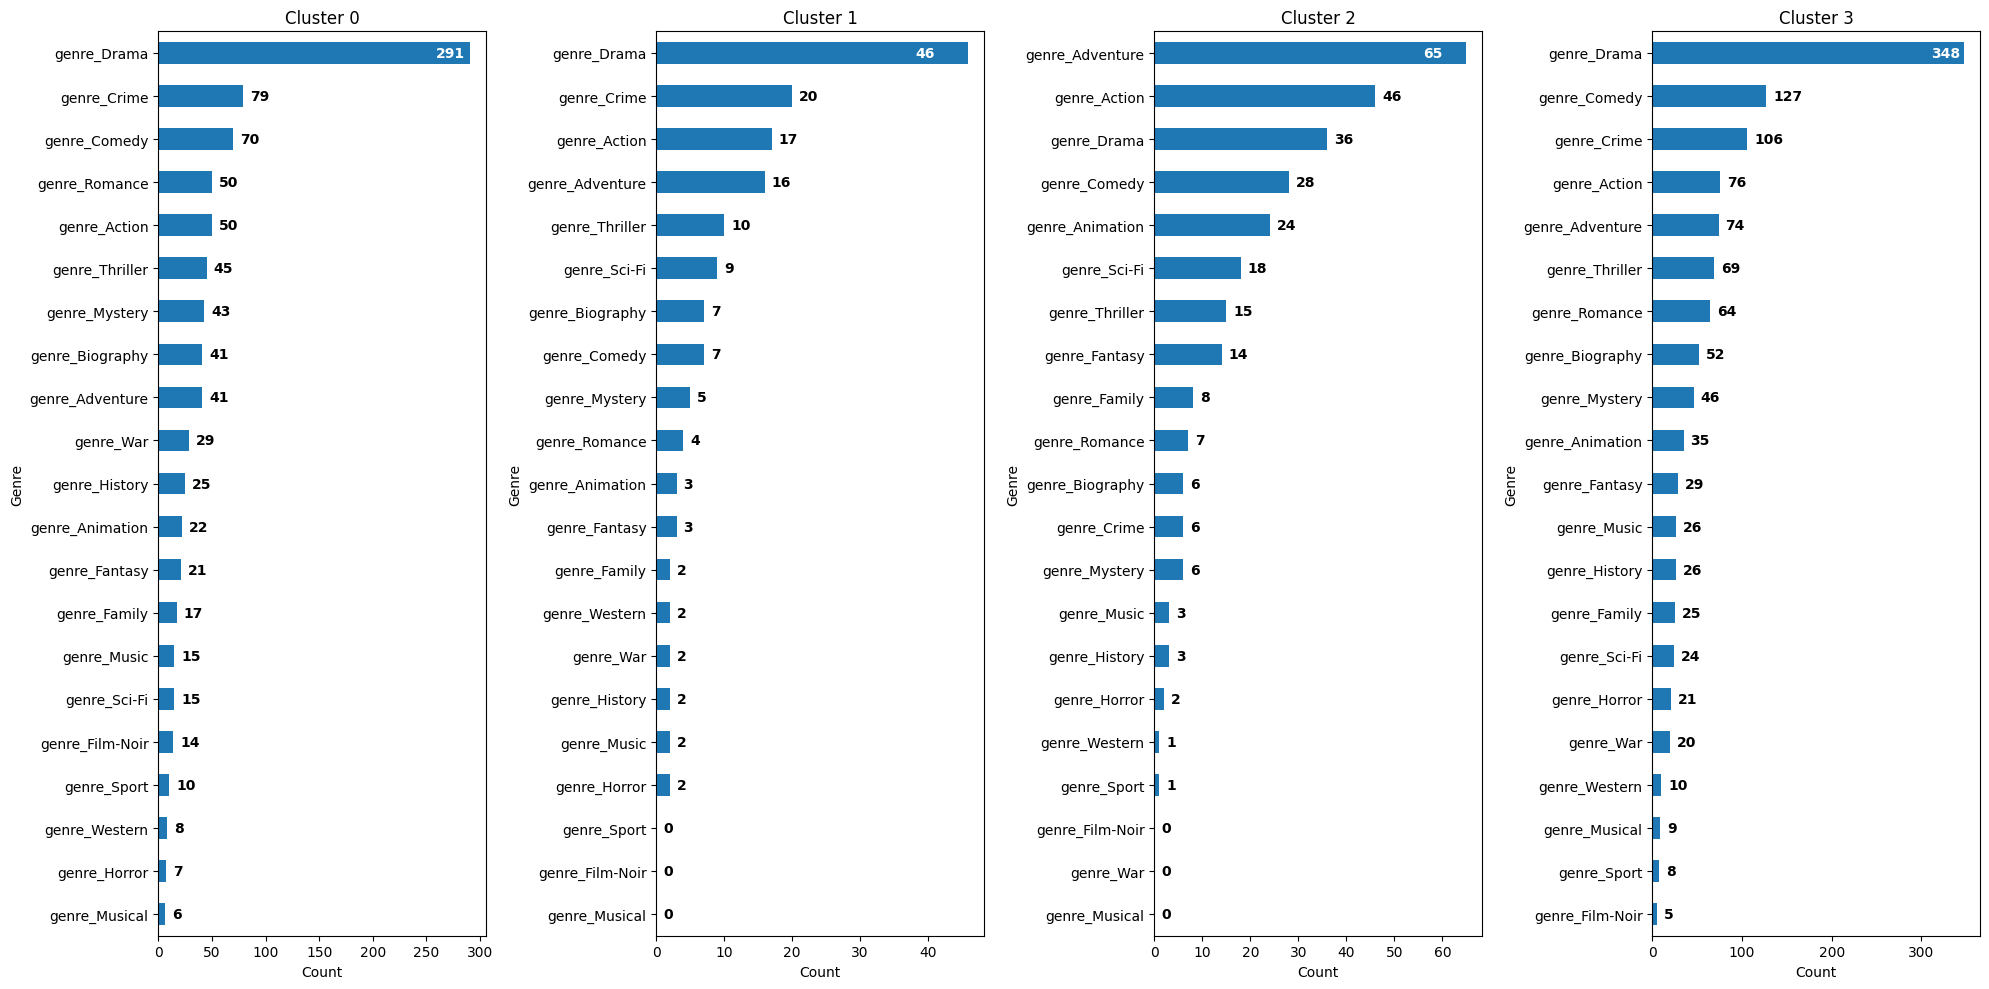

In [341]:
# Definimos las columnas de géneros
columnas_genero = [col for col in df_preprocess.columns if col.startswith('genre_')]

# Sumamos las columnas de género por cluster
genero_por_cluster = df_preprocess.groupby('cluster')[columnas_genero].sum()

# Creamos subplots de barras para cada cluster
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 10), sharey=False)

for i, ax in enumerate(axes):
    # Ordenamos los géneros de mayor a menor para cada cluster
    sorted_genres = genero_por_cluster.iloc[i].sort_values(ascending=True)
    bars = sorted_genres.plot(kind='barh', ax=ax, title=f'Cluster {i}')
    ax.set_xlabel('Count')
    ax.set_ylabel('Genre')

    # Añadimos las etiquetas de datos a cada barra
    for p in ax.patches:
        width = p.get_width()
        if width == sorted_genres.max():
            # Etiqueta dentro de la barra más común
            ax.annotate(f'{width:.0f}',
                        (width - 5, p.get_y() + p.get_height() / 2),
                        ha='right', va='center',
                        xytext=(0, 0), textcoords='offset points',
                        color='white', fontsize=10, fontweight='bold')
        else:
            # Etiqueta fuera para el resto
            ax.annotate(f'{width:.0f}',
                        (width, p.get_y() + p.get_height() / 2),
                        ha='left', va='center',
                        xytext=(5, 0), textcoords='offset points',
                        color='black', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

Ahora, vamos a ver la distribución de los años por cluster

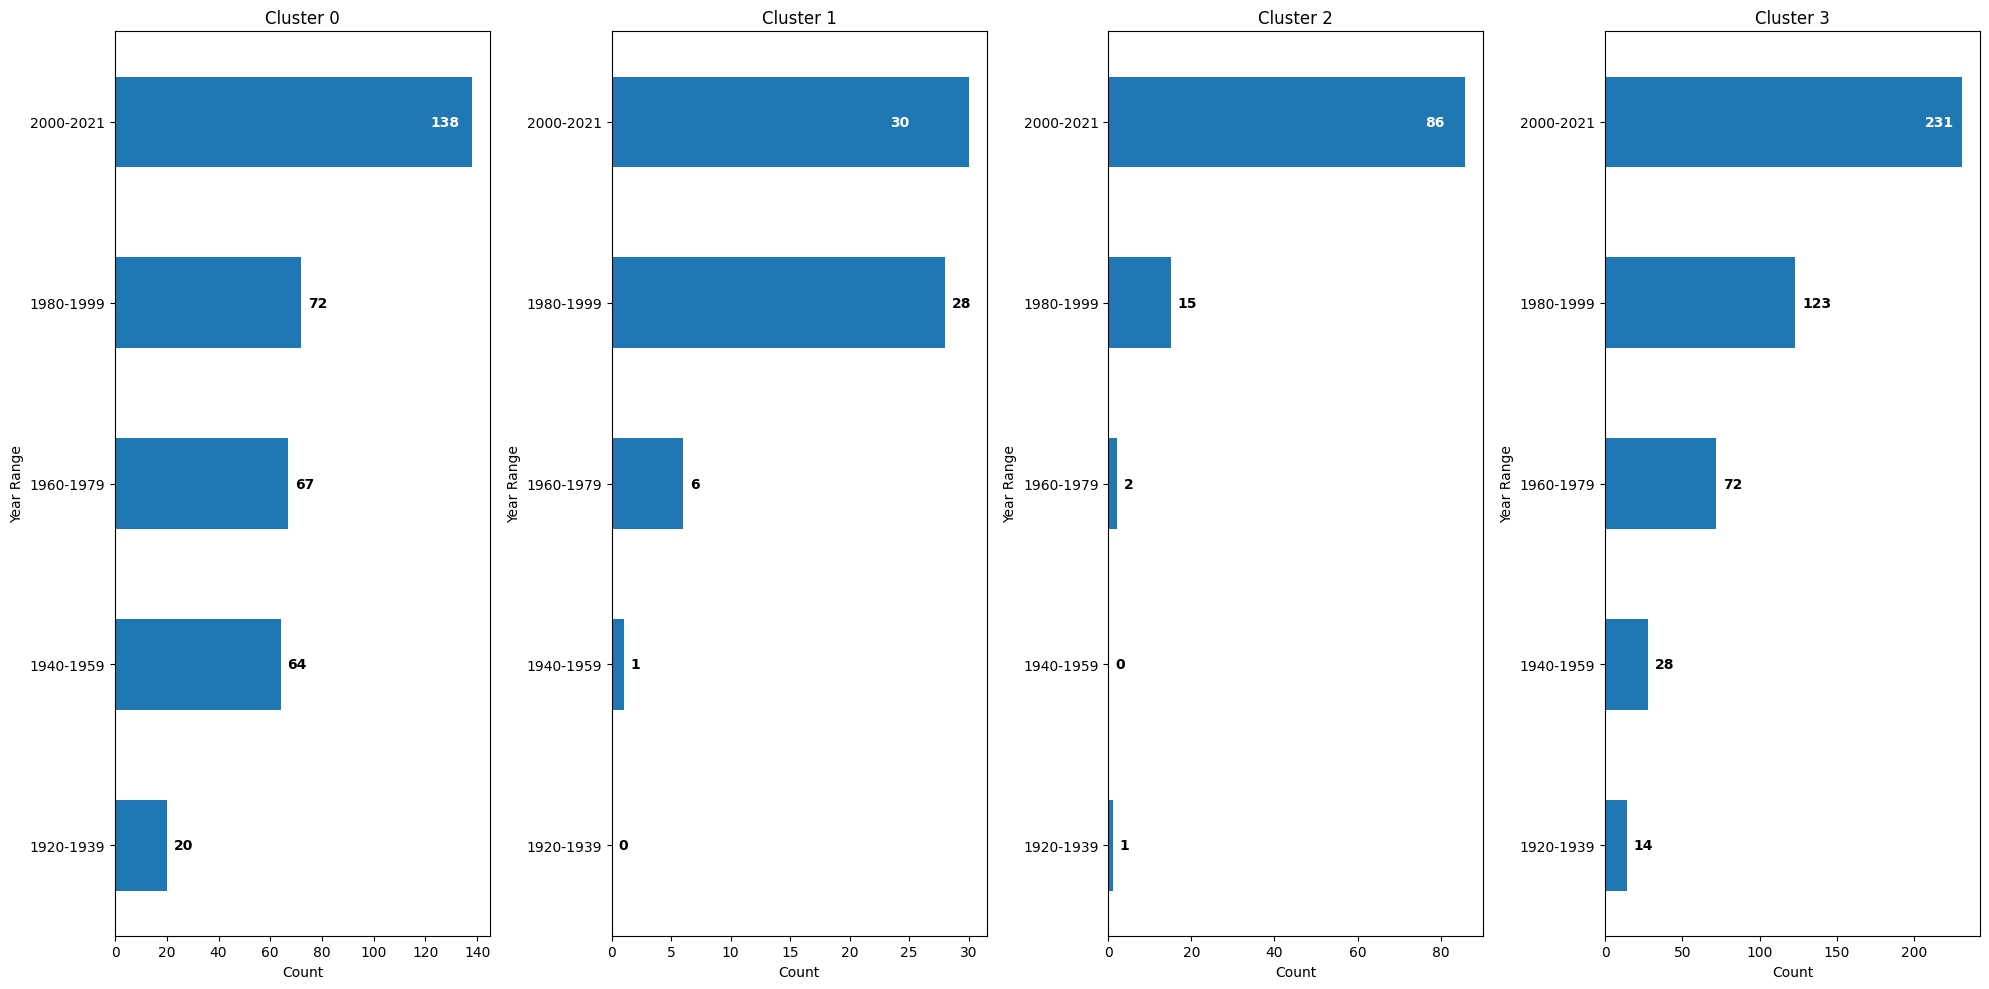

In [342]:
# Crear subplots de barras horizontales para la variable 'year' agrupada en rangos de 20 años por cada cluster
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 10), sharey=False)

# Definir los rangos de años
bins = [1920, 1940, 1960, 1980, 2000, 2021]
labels = ['1920-1939', '1940-1959', '1960-1979', '1980-1999', '2000-2021']

for i, ax in enumerate(axes):
    # Filtrar los datos por cluster
    cluster_data = df_preprocess[df_preprocess['cluster'] == i]['year']

    # Agrupar los años en rangos de 20 años
    year_groups = pd.cut(cluster_data, bins=bins, labels=labels, right=False)
    year_counts = year_groups.value_counts().sort_index()

    # Graficar los años agrupados ordenados de menor a mayor frecuencia
    bars = year_counts.plot(kind='barh', ax=ax, title=f'Cluster {i}')
    ax.set_xlabel('Count')
    ax.set_ylabel('Year Range')

    # Añadir etiquetas de datos a cada barra
    for p in ax.patches:
        width = p.get_width()
        if width == year_counts.max():
            # Etiqueta dentro de la barra más común
            ax.annotate(f'{width:.0f}',
                        (width - 5, p.get_y() + p.get_height() / 2),
                        ha='right', va='center',
                        xytext=(0, 0), textcoords='offset points',
                        color='white', fontsize=10, fontweight='bold')
        else:
            # Etiqueta fuera para el resto
            ax.annotate(f'{width:.0f}',
                        (width, p.get_y() + p.get_height() / 2),
                        ha='left', va='center',
                        xytext=(5, 0), textcoords='offset points',
                        color='black', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


Ahora, separamos cluster por cluster por medio de una máscara

### Clúster 0

Clúster 0:
                                 name  year  runtime  rating  metascore  \
2   What Ever Happened to Baby Jane?   1962      134     8.1  75.000000   
8                The Hidden Fortress   1958      126     8.1  78.158145   
13                     Before Sunset   2004       80     8.1  90.000000   
17                     Autumn Sonata   1978       99     8.2  78.158145   
20             It's a Wonderful Life   1946      130     8.6  89.000000   

                                             timeline   votes  \
2   A former child star torments her paraplegic si...   51229   
8   Lured by gold, two greedy peasants unknowingly...   35677   
13  Nine years after Jesse and Celine first met, t...  241596   
17  A married daughter who longs for her mother's ...   28818   
20  An angel is sent from Heaven to help a despera...  412456   

    gross_in_millions  genre_Drama  genre_Crime  ...  genre_Animation  \
2              4.0500            1            0  ...                0   
8

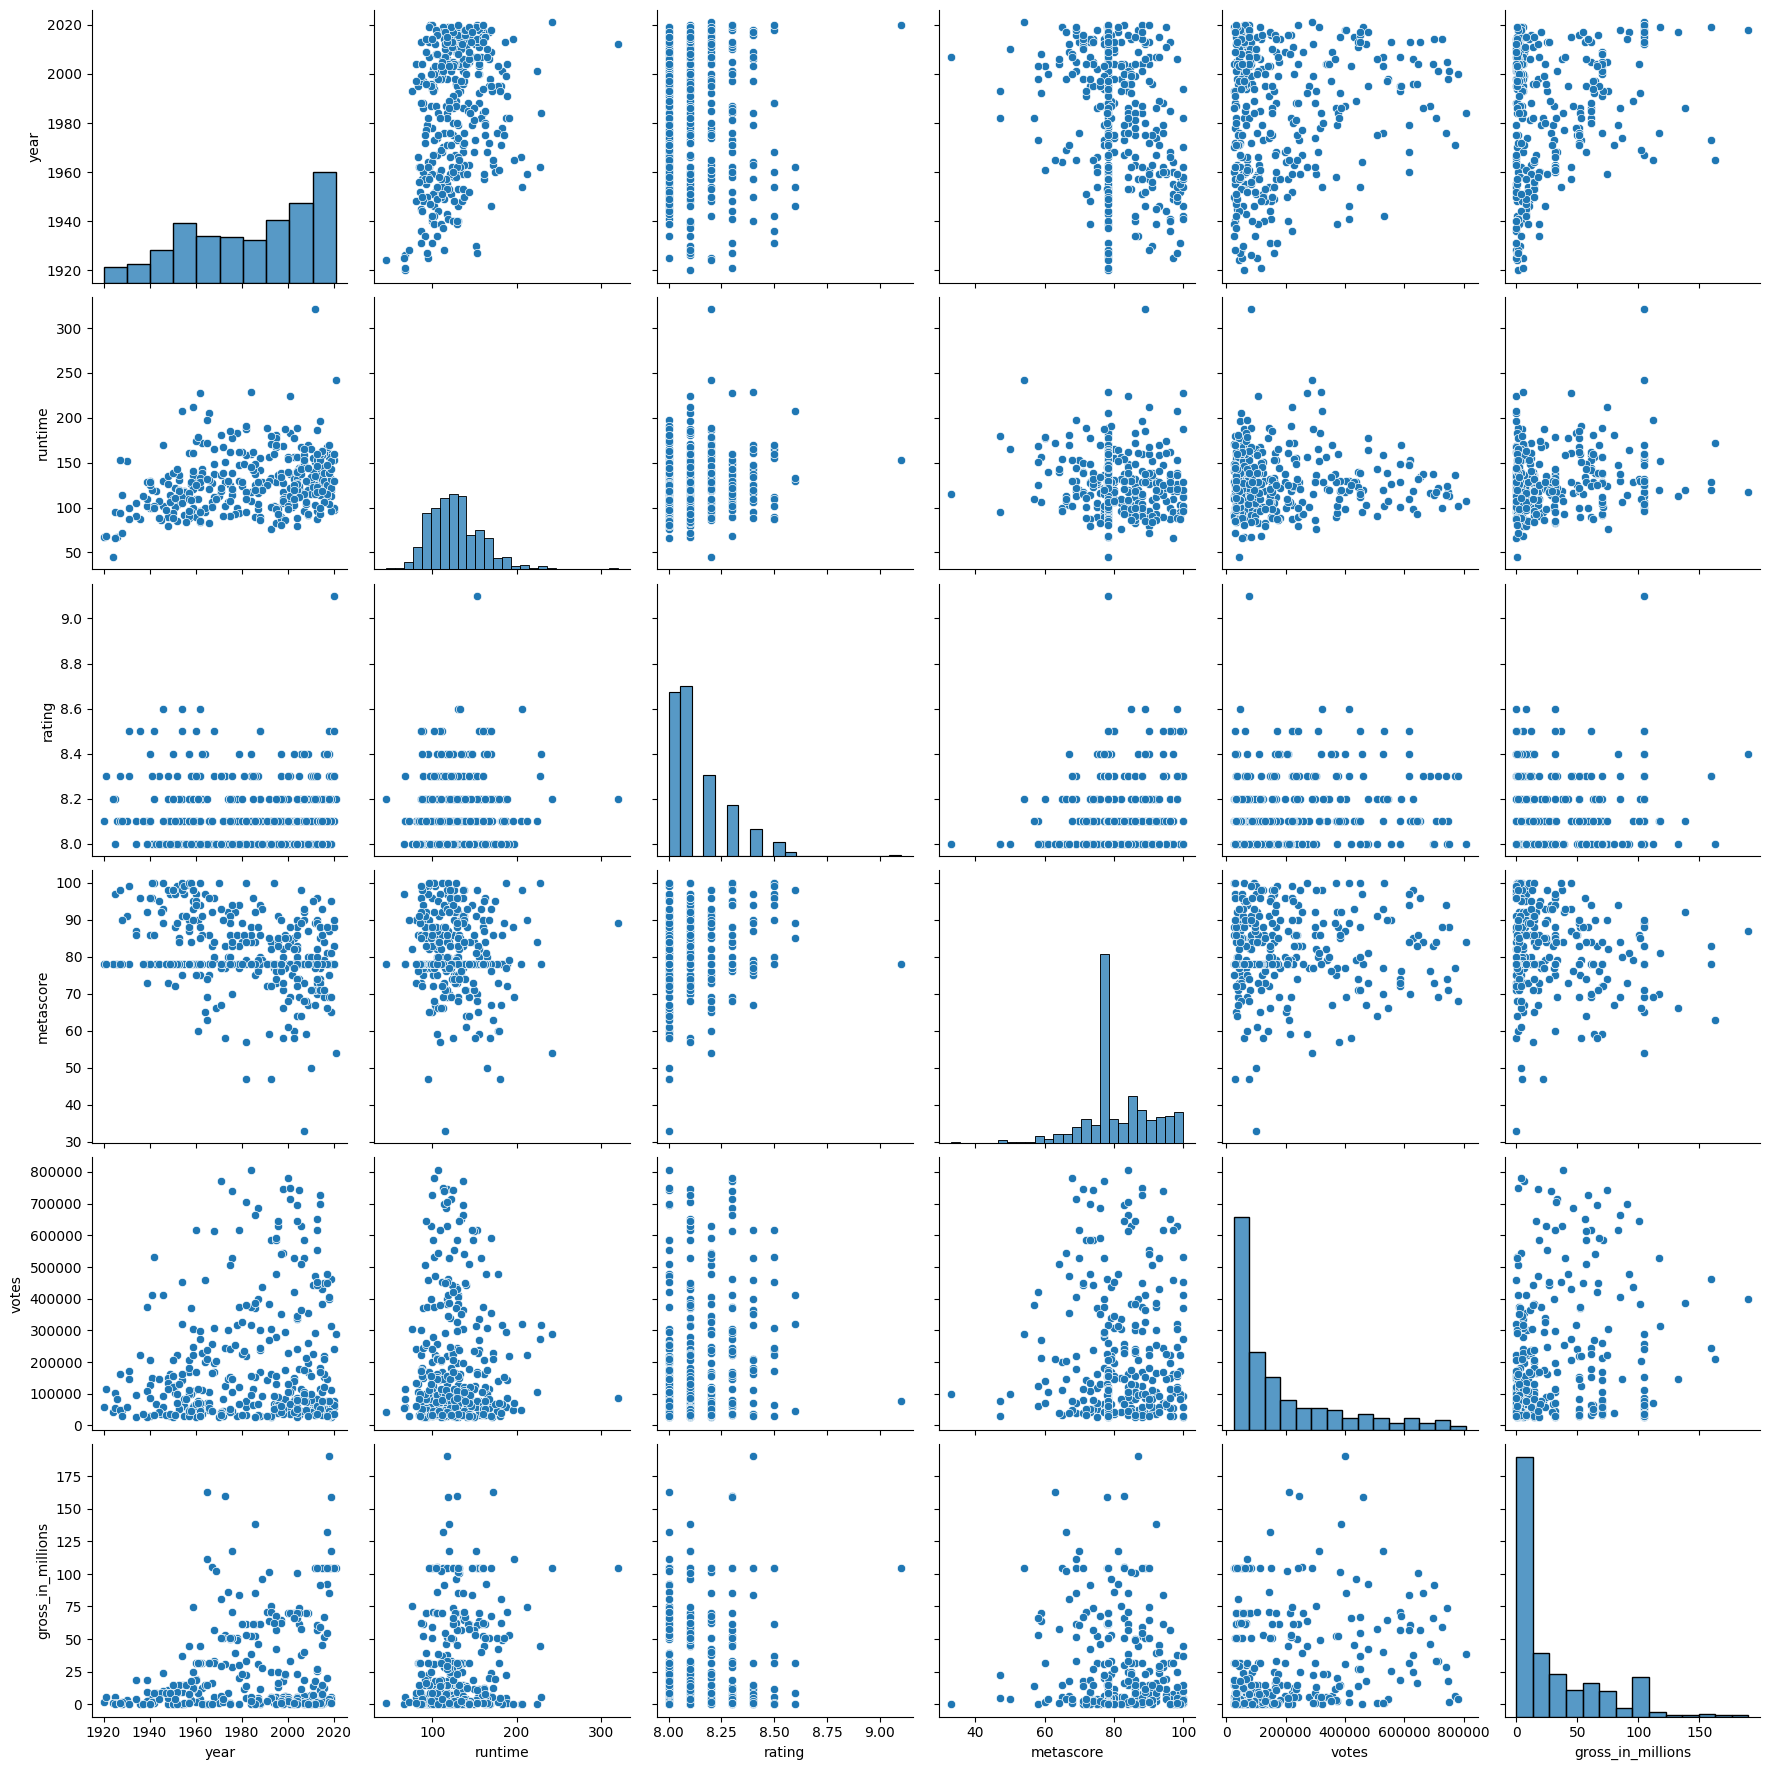

In [343]:
print("Clúster 0:")
is_G=df_preprocess.loc[:, 'cluster']==0
C3_G=df_preprocess[is_G]
print(C3_G.head())
print(C3_G.shape)

sns.pairplot(C3_G,
            height=3,
            vars=['year', 'runtime', 'rating', 'metascore', 'votes', 'gross_in_millions'],
            kind='scatter')
plt.show()

In [344]:
df_preprocess[df_preprocess['cluster'] == 0][columnas_especificas].describe()

year     runtime      rating   metascore          votes  \
count   362.000000  362.000000  362.000000  362.000000     362.000000   
mean   1984.038674  127.632597    8.137293   81.046166  186934.019337   
std      26.801696   32.066678    0.146298    9.948448  189994.563786   
min    1920.000000   45.000000    8.000000   33.000000   25116.000000   
25%    1961.000000  105.000000    8.000000   78.158145   51540.250000   
50%    1988.000000  125.000000    8.100000   78.158145  104053.000000   
75%    2008.000000  144.000000    8.200000   88.000000  247308.500000   
max    2021.000000  321.000000    9.100000  100.000000  807294.000000   

       gross_in_millions  
count         362.000000  
mean           29.920264  
std            37.113207  
min             0.010000  
25%             1.845000  
50%            12.910000  
75%            51.124500  
max           190.240000

#### Caracterización del Clúster 0

- **Películas Antigüas:** La mayoría de las películas se concentran entre 1960 y 1999
- **Duración Moderada:** Las películas tienen una duración promedio de 127,6 minutos, con una variabilidad significativa (std de 32,07)
- **Buena Calificación:** Las calificaciones son generalmente altas, alrededor de 8,14.
- **Buenas Críticas:** Los metascores son buenos, de 81.05 en promedio.
- **Baja Participación de la Audiencia:** La cantidad de votos es baja en comparación con otros cluster, en promedio de 186.934 votos, con una gran variabilidad (std de 189.994,56)
- **Bajos Ingresos:** Las películas tienden a generar bajos ingresos brutos a comparación de otros cluster, con cifras promedio de 29.92 millones de dólares, y una alta desviación estándar de 37.11 millones.


### Clúster 1

Clúster 1:
                                      name  year  runtime  rating  metascore  \
6                The Silence of the Lambs   1991      118     8.6       85.0   
15                                  Joker   2019      122     8.4       59.0   
18  The Lord of the Rings: The Two Towers   2002      179     8.7       87.0   
19                                  Alien   1979      117     8.4       89.0   
27                             Braveheart   1995      178     8.3       68.0   

                                             timeline    votes  \
6   A young F.B.I. cadet must receive the help of ...  1298483   
15  In Gotham City, mentally troubled comedian Art...   998809   
18  While Frodo and Sam edge closer to Mordor with...  1512442   
19  After a space merchant vessel receives an unkn...   802900   
27  Scottish warrior William Wallace leads his cou...   972846   

    gross_in_millions  genre_Drama  genre_Crime  ...  genre_Animation  \
6              130.74            1    

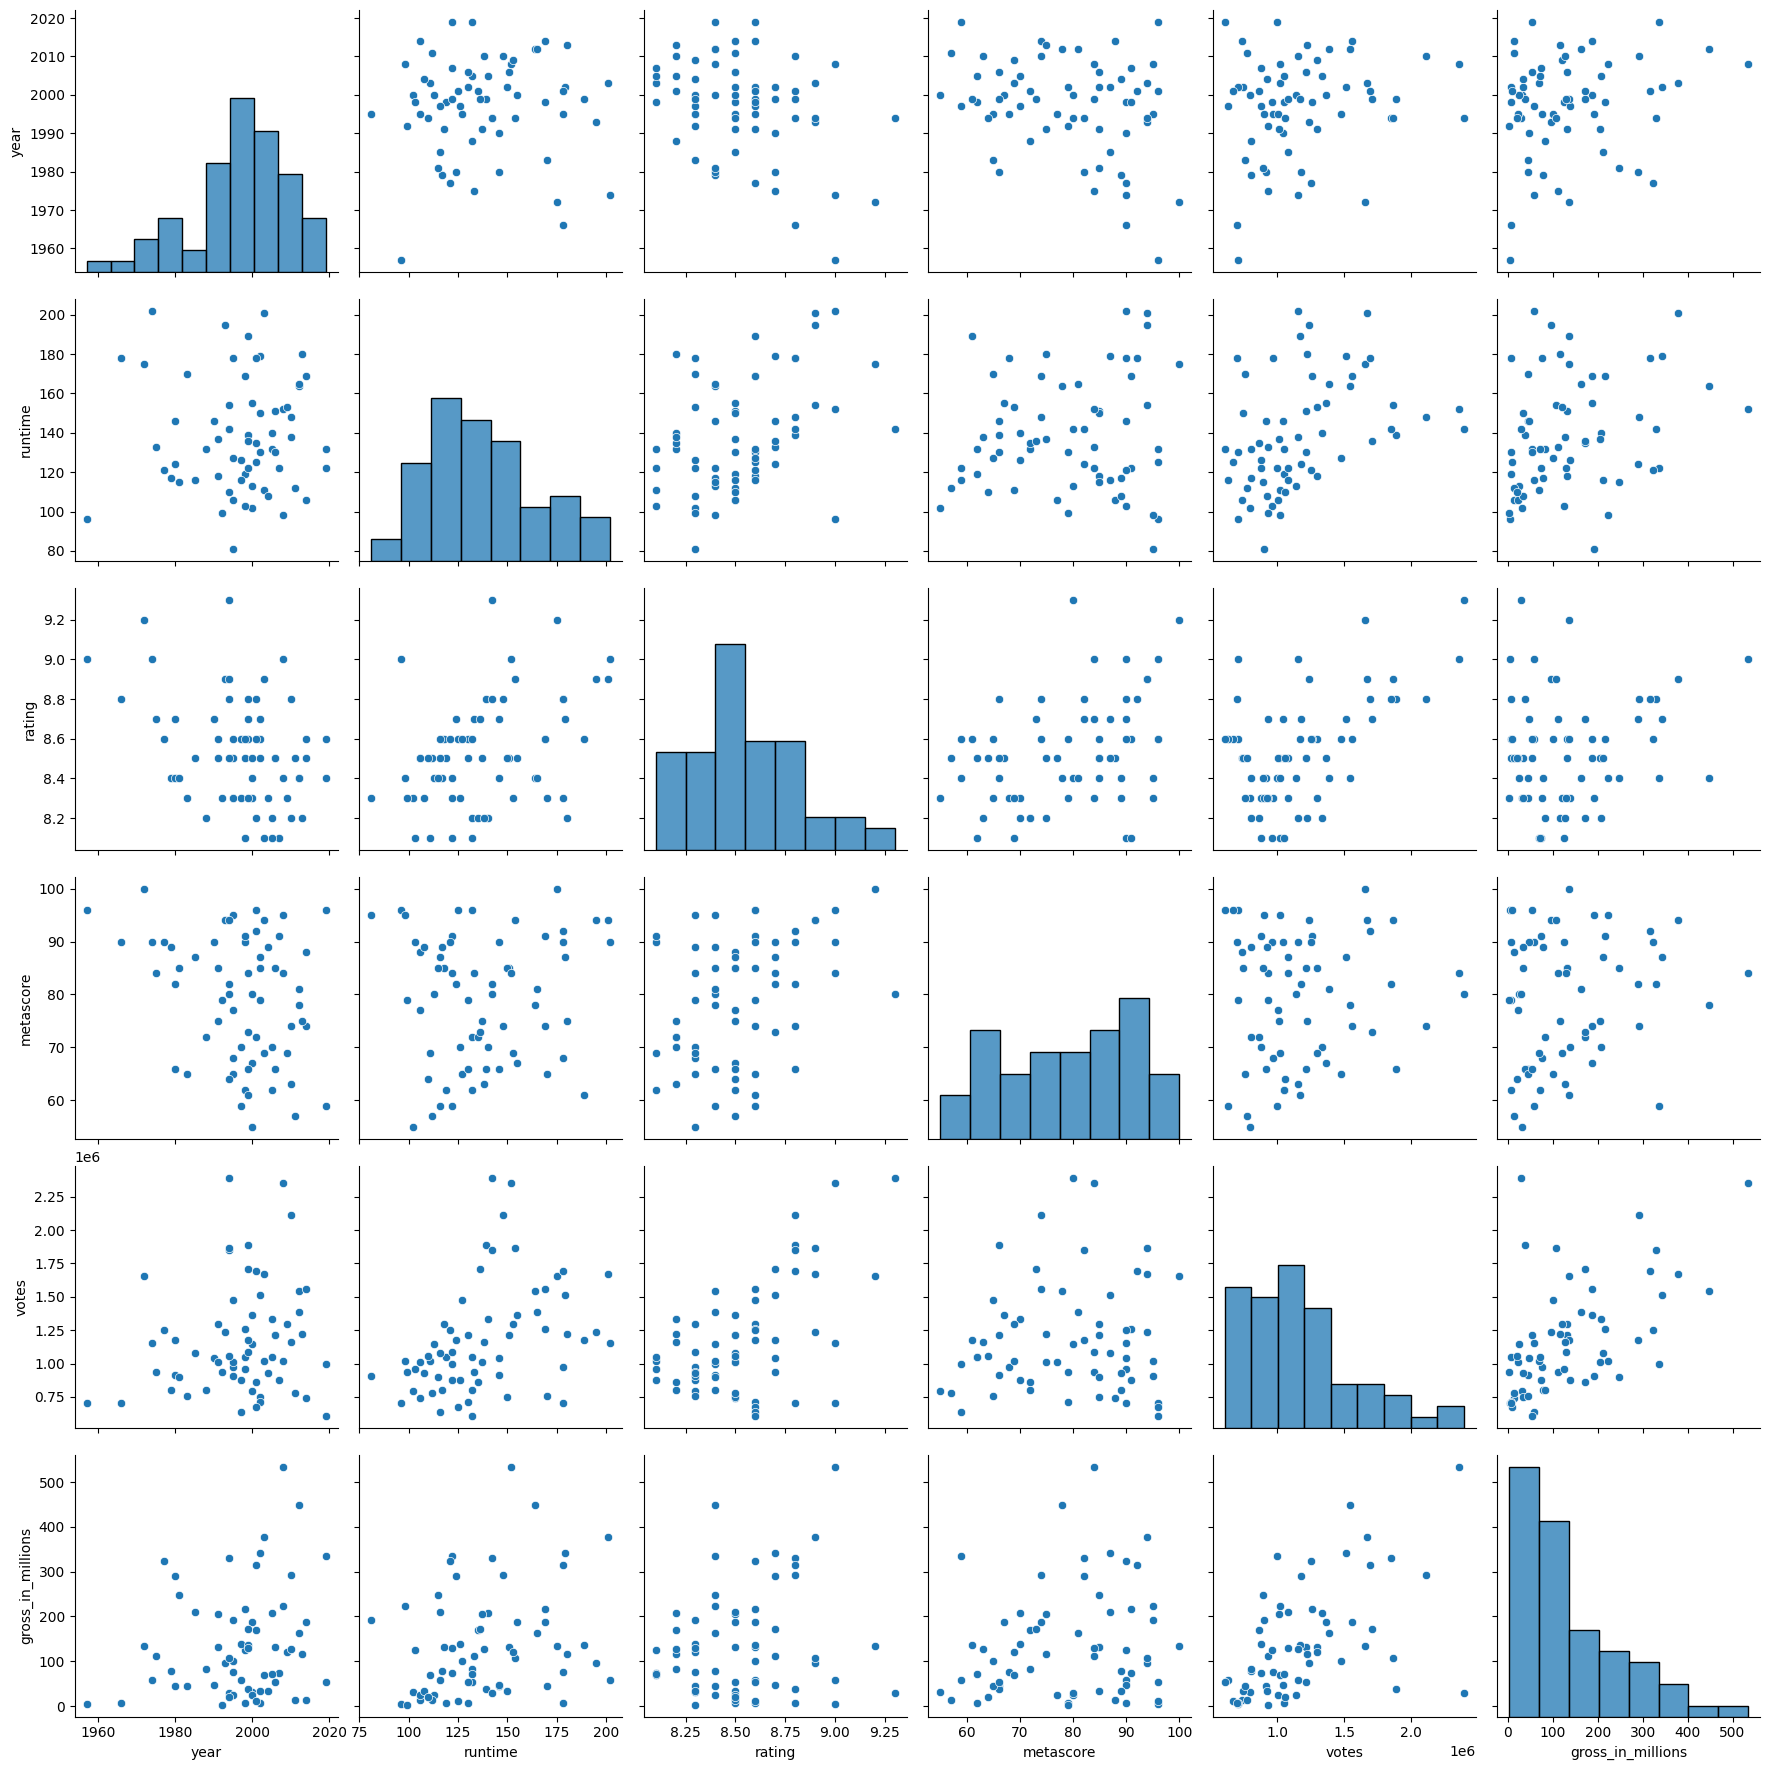

In [345]:
print("Clúster 1:")
is_G=df_preprocess.loc[:, 'cluster']==1
C3_G=df_preprocess[is_G]
print(C3_G.head())
print(C3_G.shape)

sns.pairplot(C3_G,
            height=3,
            vars=['year', 'runtime', 'rating', 'metascore', 'votes', 'gross_in_millions'],
            kind='scatter')
plt.show()

In [346]:
df_preprocess[df_preprocess['cluster'] == 1][columnas_especificas].describe()

year     runtime     rating   metascore         votes  \
count    65.000000   65.000000  65.000000   65.000000  6.500000e+01   
mean   1996.938462  138.153846   8.530769   78.953846  1.171375e+06   
std      12.651429   28.090385   0.267467   11.988837  4.052678e+05   
min    1957.000000   81.000000   8.100000   55.000000  6.084060e+05   
25%    1992.000000  117.000000   8.300000   69.000000  8.973220e+05   
50%    1999.000000  133.000000   8.500000   80.000000  1.056159e+06   
75%    2005.000000  154.000000   8.700000   90.000000  1.332341e+06   
max    2019.000000  202.000000   9.300000  100.000000  2.394059e+06   

       gross_in_millions  
count          65.000000  
mean          135.237385  
std           118.945677  
min             2.830000  
25%            44.020000  
50%           112.000000  
75%           191.800000  
max           534.860000

#### Caracterización del Clúster 1

- **Películas alrededor de los 90s:** La mayor parte de las películas se concentra entre 1990 e inicios de los 2000s.
- **Duración Larga:** Las películas tienen una duración promedio de 138 minutos.
- **Muy Buena Calificación:** Las calificaciones son muy buenas, en promedio de 8,53.
- **Buenas Críticas:** Los metascores son buenos, pero más bajos en comparación con el Clúster 0, siendo en promedio de 78,95.
- **Alta Participación de la Audiencia:** La cantidad de votos es muy alta, siendo de 1.171.375 en promedio.
- **Ingresos Altos:** Las películas tienden a generar ingresos altos, con más éxitos de taquilla en comparación con el Clúster 0 pero menos en comparación con el Clúster 2, siendo en promedio de 135,24 millones de dólares.


### Clúster 2

Clúster 2:
                                             name  year  runtime  rating  \
7                       How to Train Your Dragon   2010       98     8.1   
21                                Thor: Ragnarok   2017      130     7.9   
28  Harry Potter and the Deathly Hallows: Part 1   2010      146     7.7   
37                                  The Avengers   2012      143     8.0   
63                                         Logan   2017      137     8.1   

    metascore                                           timeline    votes  \
7        75.0  A hapless young Viking who aspires to hunt dra...   678716   
21       74.0  Imprisoned on the planet Sakaar, Thor must rac...   613362   
28       65.0  As Harry, Ron, and Hermione race against time ...   489893   
37       69.0  Earth's mightiest heroes must come together an...  1281636   
63       77.0  In a future where mutants are nearly extinct, ...   665875   

    gross_in_millions  genre_Drama  genre_Crime  ...  genre_Animation

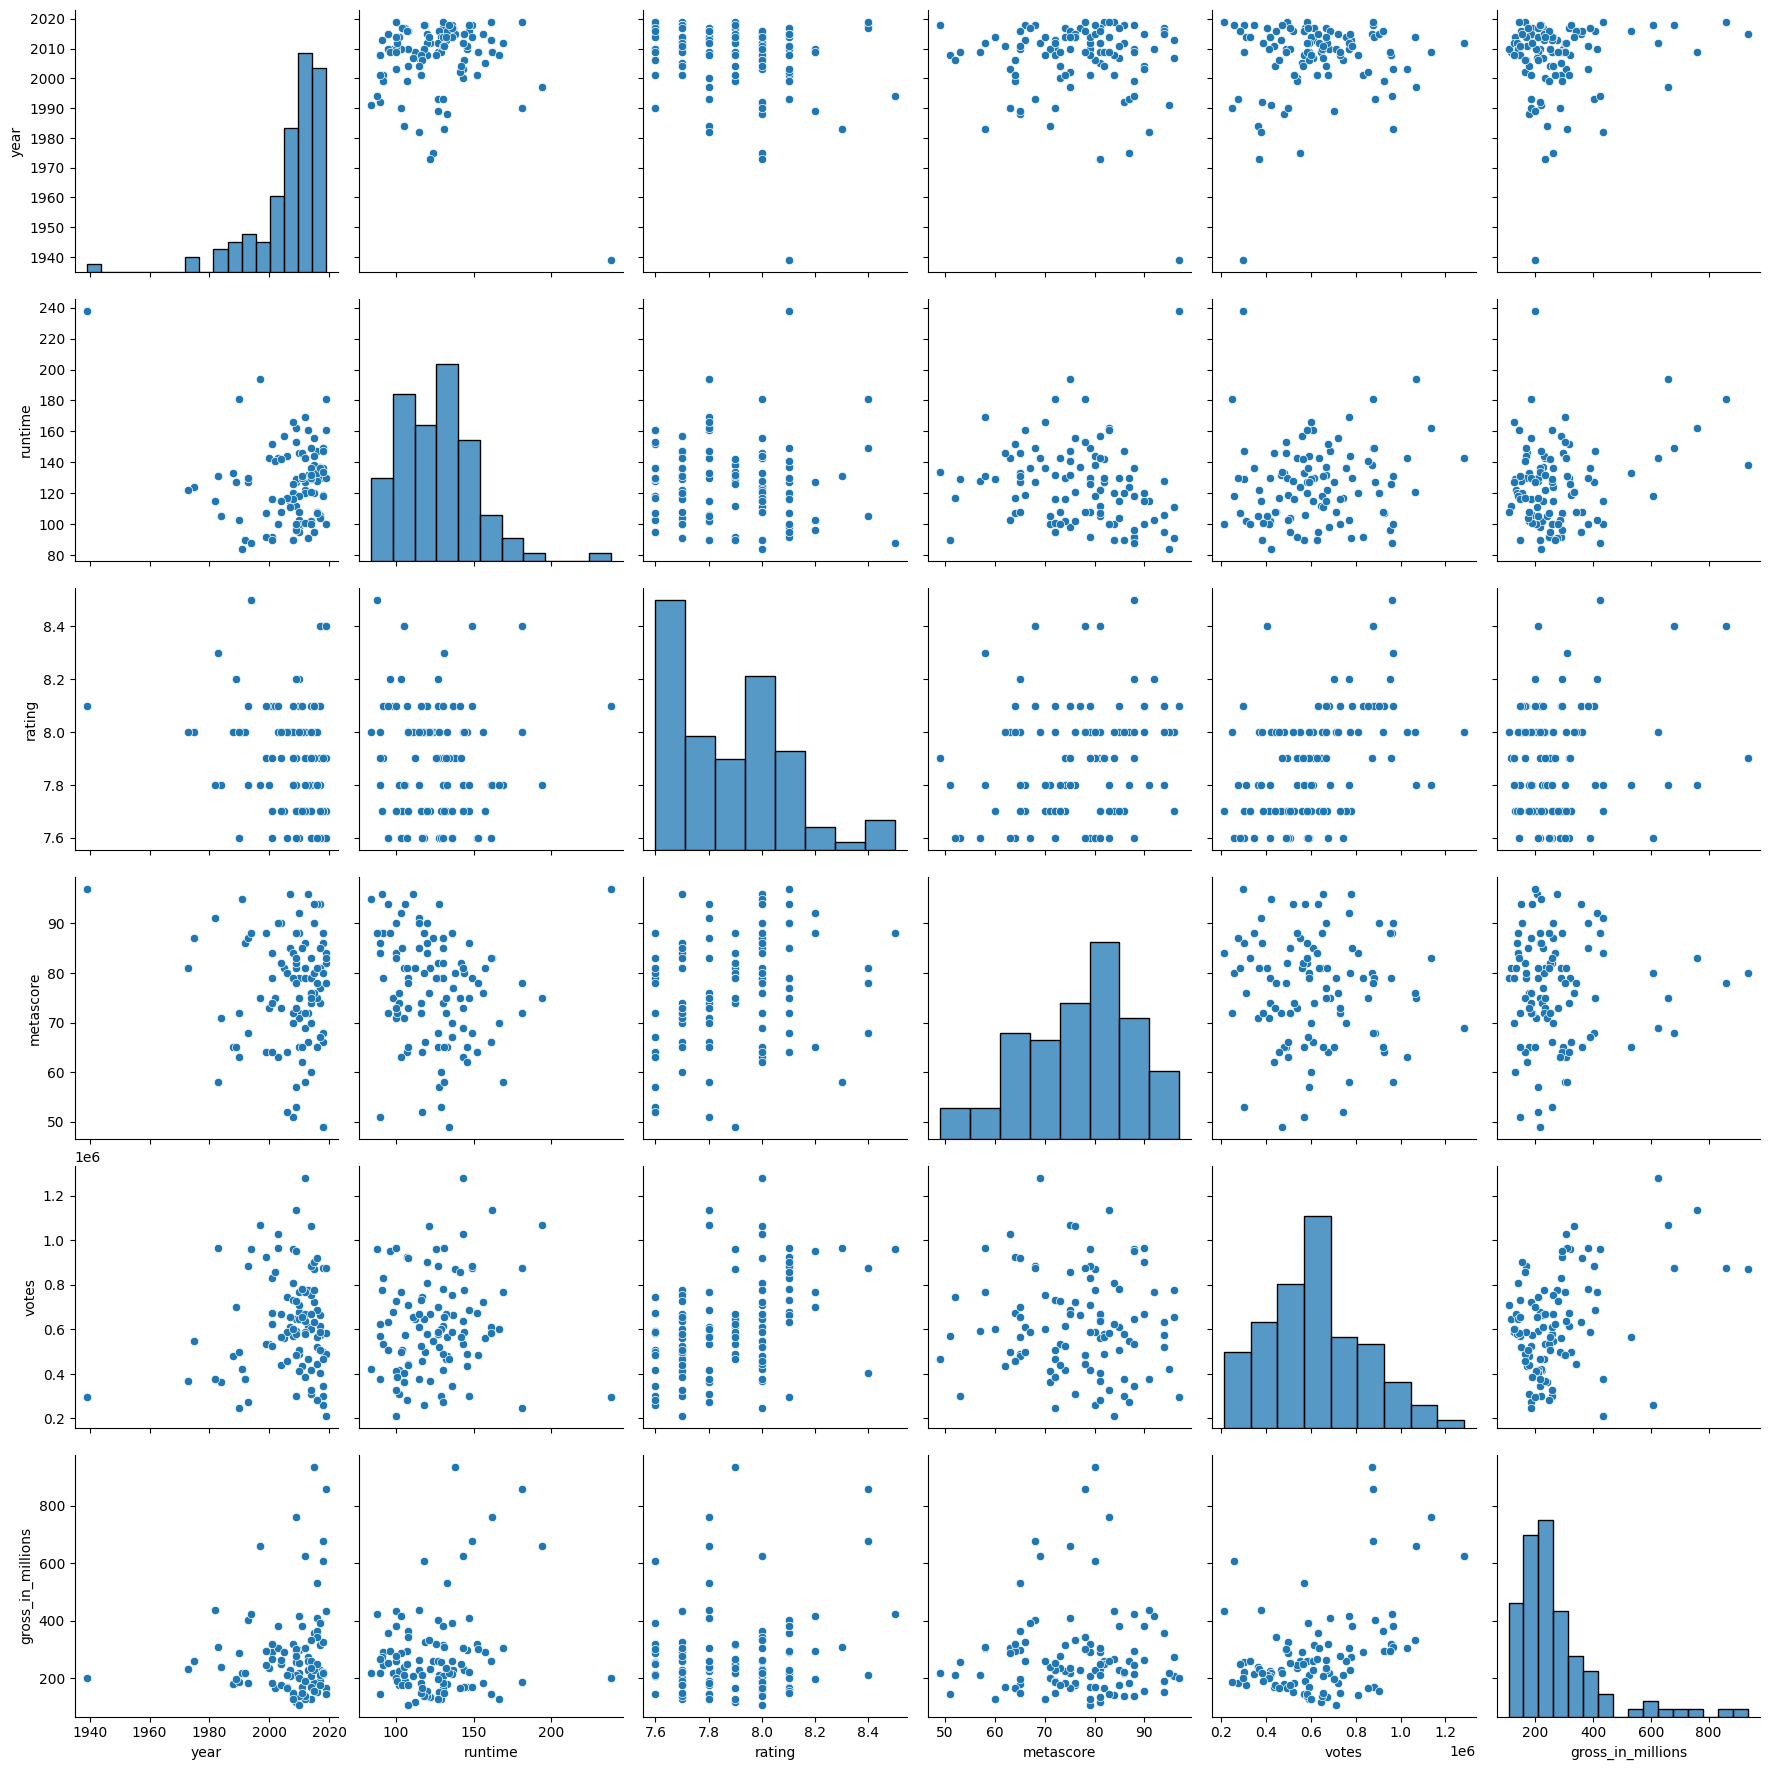

In [347]:
print("Clúster 2:")
is_G=df_preprocess.loc[:, 'cluster']==2
C3_G=df_preprocess[is_G]
print(C3_G.head())
print(C3_G.shape)

sns.pairplot(C3_G,
            height=3,
            vars=['year', 'runtime', 'rating', 'metascore', 'votes', 'gross_in_millions'],
            kind='scatter')
plt.show()

In [348]:
df_preprocess[df_preprocess['cluster'] == 2][columnas_especificas].describe()

year     runtime      rating   metascore         votes  \
count   104.000000  104.000000  104.000000  104.000000  1.040000e+02   
mean   2007.048077  125.778846    7.889423   76.567308  6.210885e+05   
std      12.039885   25.195915    0.206646   10.788131  2.184458e+05   
min    1939.000000   84.000000    7.600000   49.000000  2.123760e+05   
25%    2003.750000  106.750000    7.700000   69.750000  4.682560e+05   
50%    2010.000000  126.500000    7.900000   78.000000  5.956250e+05   
75%    2015.000000  141.250000    8.000000   84.000000  7.583490e+05   
max    2019.000000  238.000000    8.500000   97.000000  1.281636e+06   

       gross_in_millions  
count         104.000000  
mean          276.651635  
std           151.140607  
min           106.950000  
25%           183.585000  
50%           233.775000  
75%           306.340000  
max           936.660000

#### Caracterización del Clúster 2

- **Películas Recientes:** La mayoría de las películas son de las últimas dos décadas, concentrándose más entre 2003 y 2015.
- **Duración Moderada:** Las películas tienen una duración promedio de 126 minutos.
- **Calificación Moderada:** El promedio de calificaciones es más bajo que los cluster 0 y 1, pero más alto que el del cluster 3, siendo de 7,89.
- **Críticas Moderadas:** Los metascores cumplen el mismo patrón que la calificación, es decir, más bajo que los cluster 0 y 1, pero más alto que el cluster 3, siendo de 76,57.
- **Alta Participación de la Audiencia:** La cantidad de votos es alta (aunque más baja que en el cluster 1), siendo de alrededor de 621.089 votos.
- **Muy Buenos Ingresos:** Las películas tienden a generar ingresos muy altos, en promedio de 276.65 millones de dólares.


### Clúster 3

Clúster 3:
                                  name  year  runtime  rating  metascore  \
0                     The Jungle Book   1967       78     7.6       65.0   
1  The Taking of Pelham One Two Three   1974      104     7.7       68.0   
3                      The Wild Bunch   1969      135     7.9       97.0   
4        The Double Life of Véronique   1991       98     7.8       86.0   
5                      Only Yesterday   1991      118     7.6       90.0   

                                            timeline   votes  \
0  Bagheera the Panther and Baloo the Bear have a...  168985   
1  In New York, armed men hijack a subway car and...   27423   
3  An aging group of outlaws look for one last bi...   78505   
4  Two parallel stories about two identical women...   43720   
5  A twenty-seven-year-old office worker travels ...   28254   

   gross_in_millions  genre_Drama  genre_Crime  ...  genre_Animation  \
0             141.84            0            0  ...                1   
1  

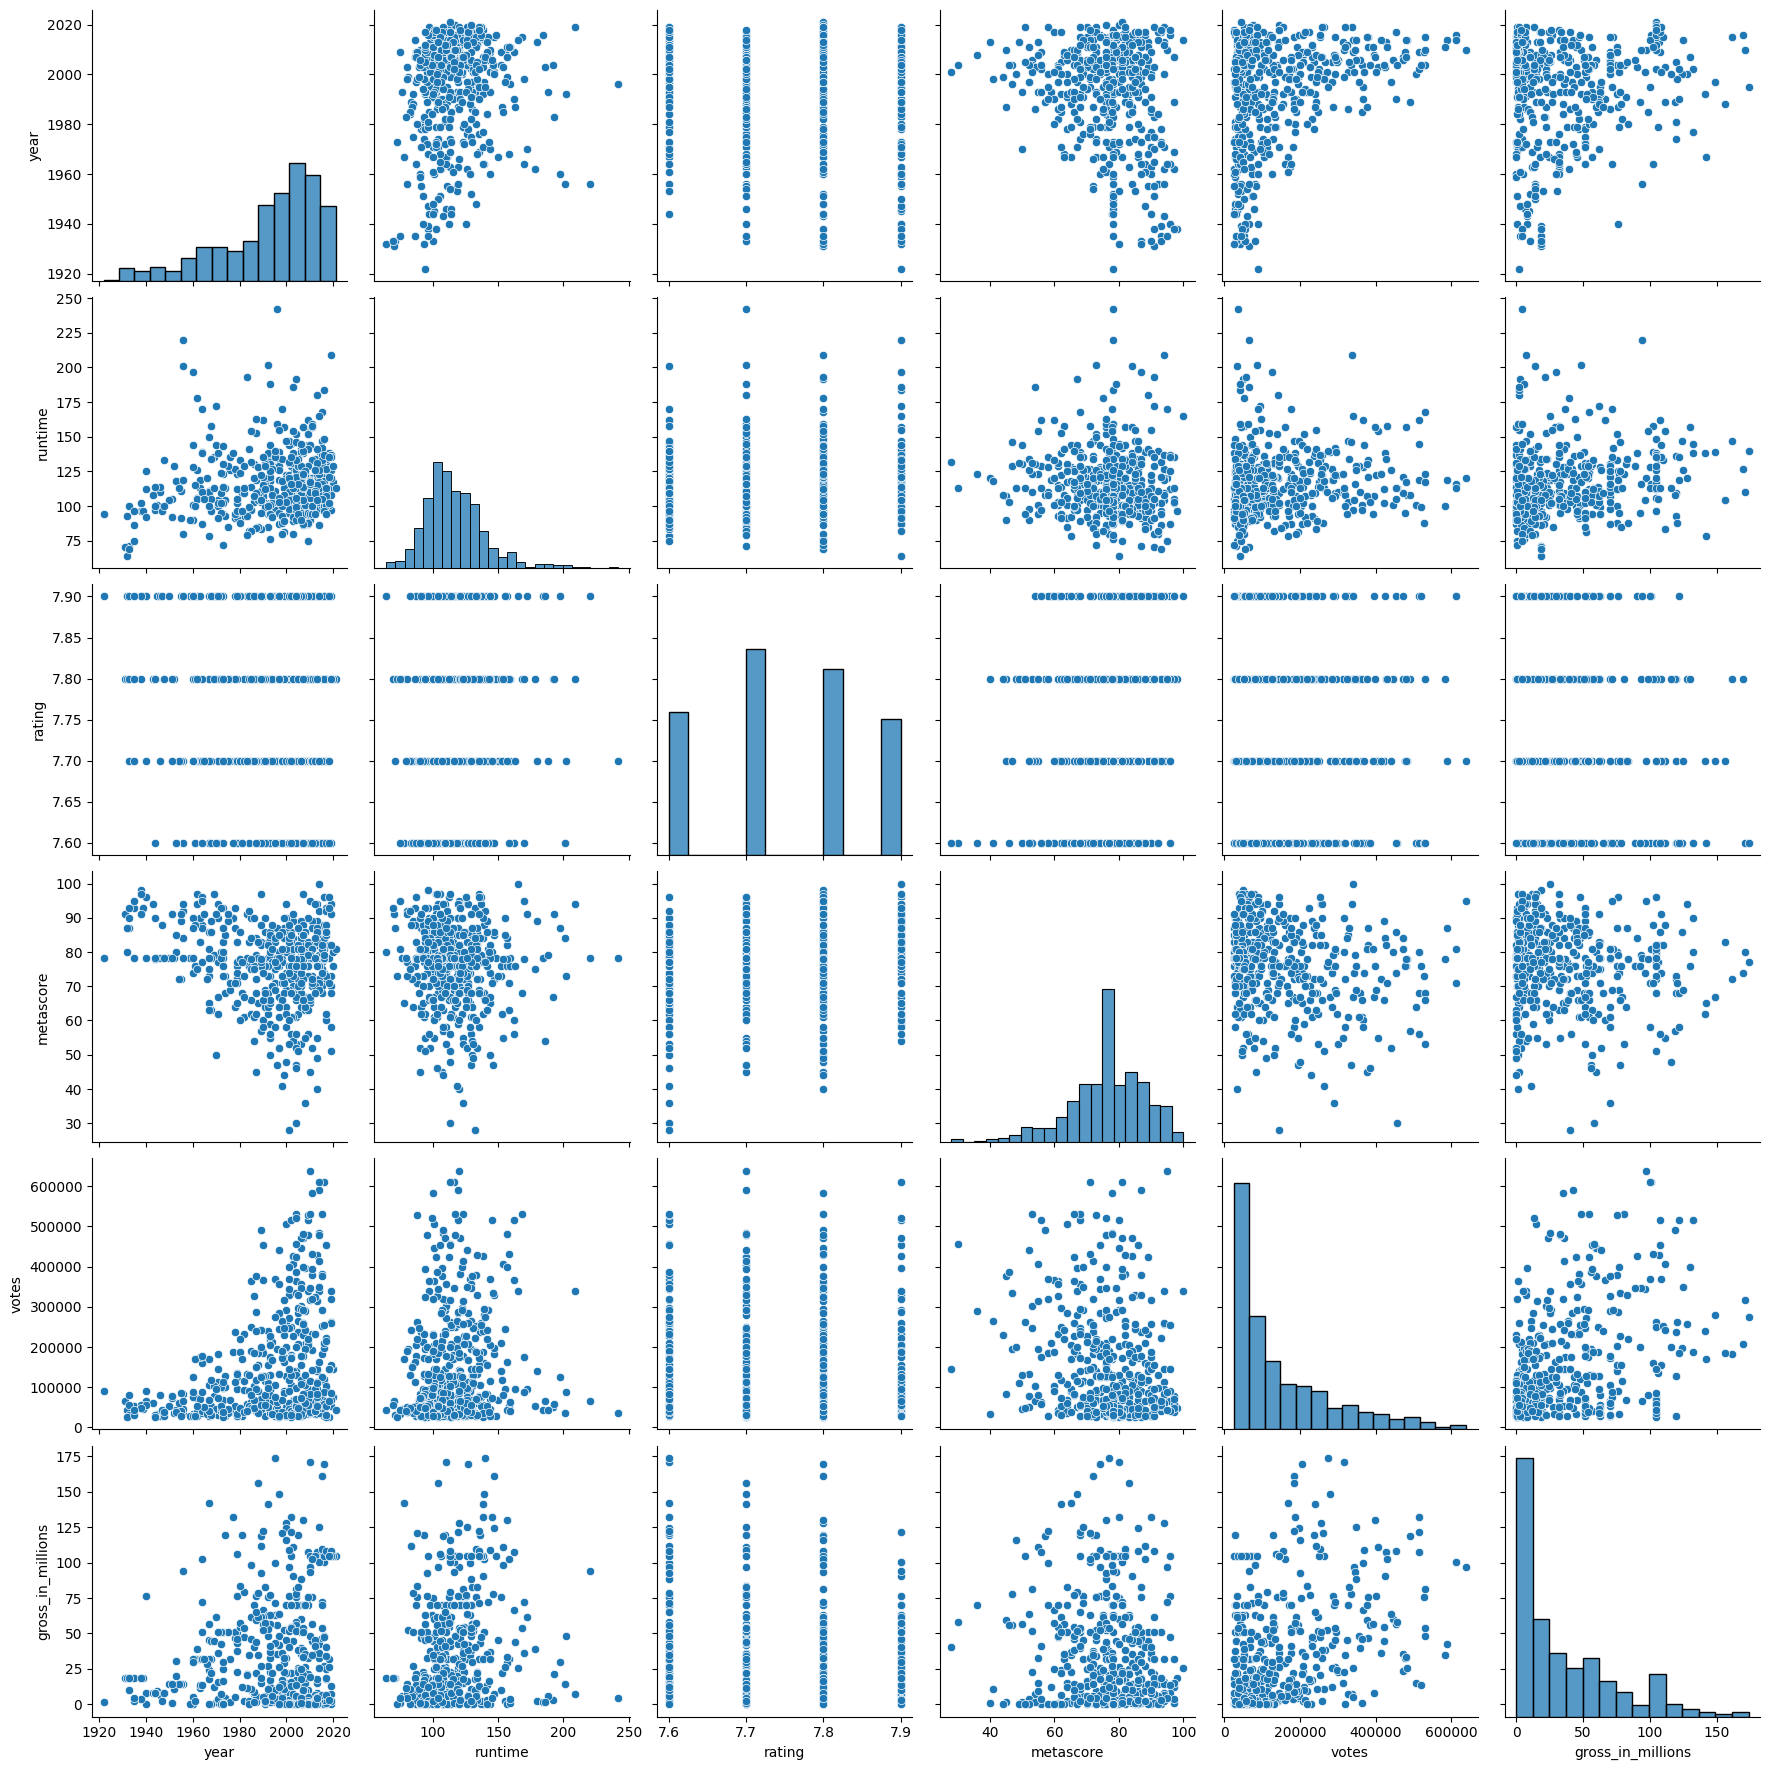

In [349]:
print("Clúster 3:")
is_G=df_preprocess.loc[:, 'cluster']==3
C3_G=df_preprocess[is_G]
print(C3_G.head())
print(C3_G.shape)

sns.pairplot(C3_G,
            height=3,
            vars=['year', 'runtime', 'rating', 'metascore', 'votes', 'gross_in_millions'],
            kind='scatter')
plt.show()

In [350]:
df_preprocess[df_preprocess['cluster'] == 3][columnas_especificas].describe()

year     runtime      rating   metascore          votes  \
count   469.000000  469.000000  469.000000  469.000000     469.000000   
mean   1992.498934  116.744136    7.746908   76.171499  150715.439232   
std      21.435914   23.849927    0.104063   11.764436  134609.775310   
min    1922.000000   64.000000    7.600000   28.000000   25213.000000   
25%    1981.000000  101.000000    7.700000   70.000000   49117.000000   
50%    1999.000000  113.000000    7.700000   78.158145   95488.000000   
75%    2008.000000  129.000000    7.800000   84.000000  210552.000000   
max    2021.000000  242.000000    7.900000  100.000000  638783.000000   

       gross_in_millions  
count         469.000000  
mean           36.117007  
std            38.302911  
min             0.000000  
25%             4.420000  
50%            22.000000  
75%            56.120000  
max           173.840000

#### Caracterización del Clúster 3

- **Películas moderadamente recientes:** La mayoría de películas se concentra en las últimas dos décadas, teniendo una mayor distribución entre los años 1981 y 2008.
- **Duración Corta:** Las películas tienen una duración promedio corta, de 117 minutos.
- **Calificación moderada:** Las calificaciones son menores al resto de clústeres, siendo en promedio de 7,75.
- **Críticas moderadas:** Los metascores son menores al resto de clústeres, siendo en promedio de 76,17.
- **Participación Baja de la Audiencia:** La cantidad de votos es baja, en promedio de 150.715 votos, con una desviación estándar de 134.609,78
- **Ingresos Bajos:** Las películas tienden a generar ingresos brutos bajos, en promedio de 36,12 millones de dólares, con una desviación estándar de 38,30 millones de dólares.


## Tendencias Encontradas en los Datos


Para las tendencias se destacan diferentes características de las películas, como el año de producción, duración, calificación, participación de la audiencia y los ingresos, como estas características interactúan y afectan la percepción y el rendimiento de las películas en el mercado.

1. **Películas Antiguas con Buenas Críticas en el Cluster 0**

    Las películas en el Cluster 0 son mayormente producidas entre 1960 y 1999. Tienen buenas calificaciones (promedio de 8,14) y excelentes metascores (promedio de 81,05). Sin embargo, reciben menos votos (promedio de 186.934) y generan menores ingresos (29,92 millones de dólares en promedio). Esta tendencia sugiere que, aunque son bien valoradas, la antigüedad de las películas puede limitar su popularidad y rentabilidad actual.

2. **Alta Popularidad y Rendimiento Financiero en el Cluster 1**

    El Cluster 1 agrupa películas de los años 90 e inicios de los 2000. Estas películas tienen calificaciones muy altas (promedio de 8,53) y reciben una gran cantidad de votos (promedio de 1.171.375), además de generar ingresos significativos (135,24 millones de dólares en promedio). La alta participación de la audiencia y el buen desempeño financiero reflejan una fuerte aceptación y apreciación del público por estas películas.

3. **Películas Recientes con Alto Desempeño Financiero en el Cluster 2**

    Las películas del Cluster 2 son recientes (mayoritariamente de 2003 a 2015) y generan los mayores ingresos brutos (276,65 millones de dólares en promedio). Aunque sus calificaciones (promedio de 7,89) y metascores (promedio de 76,57) no son las más altas, la popularidad (621.089 votos en promedio) y el alto rendimiento financiero indican que las películas recientes atraen a un amplio público y son altamente rentables.

4. **Moderado Desempeño en el Cluster 3**

    El Cluster 3 incluye películas con una amplia distribución temporal (1981 a 2008) y duración corta (117 minutos en promedio). Estas películas tienen calificaciones y metascores moderados (promedio de 7,75 y 76,17 respectivamente), reciben menos votos (150.715 en promedio) y generan menores ingresos (36,12 millones de dólares en promedio). La diversidad de géneros en este cluster puede atraer a diferentes segmentos de audiencia, pero el desempeño financiero y la participación son más bajos.

5. **Alta Participación de la Audiencia y Desempeño Financiero en los Clusters 1 y 2**

    Las películas en los Clusters 1 y 2 atraen a un gran número de espectadores, con un promedio de 1,171,375 votos en el Cluster 1 y 621,089 votos en el Cluster 2. Además, muestran un excelente rendimiento financiero, con ingresos promedio de 276.65 millones de dólares en el Cluster 2 y 135.24 millones en el Cluster 1. Esta tendencia sugiere que las películas recientes y populares no solo atraen a una gran audiencia, sino que también son altamente rentables, reflejando un fuerte interés y compromiso del público.
